## 5uls -preN

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import pca, diffusionmap, align, rms, distances, contacts
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from numpy.linalg import norm
import nglview as nv
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#%matplotlib notebook
#import mpld3
#mpld3.enable_notebook()

In [2]:
uls1 = "/home/alaooj/namd/5uls/"
uls2 = "/home/alaooj/namd/5uls2/"
psf = '/prep/namd/step3_charmm2namd.psf'
dcd = '/prep/namd/eq_all.dcd'

In [3]:
# load in your trajectories
u = mda.Universe(uls1 + '5uls-atp' +psf, uls1 + '5uls-atp' +dcd)
u1 = mda.Universe(uls1 + '5uls-adpatp' +psf, uls1+ '5uls-adpatp' +dcd) 
u2 = mda.Universe(uls1 + '5uls-adppi' +psf, uls1 + '5uls-adppi' +dcd)
u3 = mda.Universe(uls1 + '5uls-apo' +psf, uls1 +'5uls-apo/prep/namd/eq_all_unwrap.dcd')
#ref = mda.Universe('step1_pdbreader.psf', 'tmd-pep-grp94-closing-6.traj1.move1.dcd') 
#u = mda.Universe(uls1 + '5uls-atp' +psf, uls1+ '5uls-anp/prep/namd/eq_all_unwrap.dcd')  

In [4]:
#load traj into dict
uni = {'ATP': u, 'ATPADP' : u1 , 'ADPPI' : u2, 'APO': u3}

In [5]:
#name collection def
name_collection = ["ATP_A",'ATP_B', "ATPADP_A",'ATPADP_B', "ADPPI_A",'ADPPI_B', "APO_A",'APO_B']
name_collection1 = ["ATP", "ATP/ADP", 'ADP-$P_i$','apo']

The parameters for subplot are: number of rows, number of columns, and which subplot you're currently on. So 1, 2, 1 means "a 1-row, 2-column figure: go to the first subplot." Then 1, 2, 2 means "a 1-row, 2-column figure: go to the second subplot."

In [241]:
print(name_collection1[2])

ADP-P$_{i}$


### Define all interested selections

In [ ]:
# nosolv = u.select_atoms('protein or resname ANP or resname MG')
# protein = u.select_atoms('protein')
# nocha = nosolv.select_atoms('not resid 265-321')
# NTD = u.select_atoms("resid 87-265  and name CA")    
# MD = u.select_atoms("resid 322-581 and name CA")
# CTD = u.select_atoms("resid 582-747 and name CA")
# #PEP = u.select_atoms("segid PEP and name CA")
# CHA = u.select_atoms("resid 265-321 and name CA")

#gewirth 2017
# new charge linker cut off 281-337
# NTD 87-280
# MD 281 593
# CTD 594 747


# RSMD

In [9]:
# RMSD of domains per chain
NTDA = 'backbone and segid PROA and resid 87-280' #note NTD starts from 74 for 5uls
#CHAA = 'backbone and segid PROA and resid 281-337'
MDA = 'backbone and segid PROA and resid 338-593'
CTDA = 'backbone and segid PROA and resid 594-747'
BBA = 'backbone and segid PROA and not resid 281-337'

NTDB = 'backbone and segid PROB and resid 87-280' #note NTD starts from 74 for 5uls
#CHAB = 'backbone and segid PROB and resid 281-337'
MDB = 'backbone and segid PROB and resid 338-593'
CTDB = 'backbone and segid PROB and resid 594-747'
BBB = 'backbone and segid PROB and not resid 281-337'

proa = 'backbone and segid PROA'
prob = 'backbone and segid PROB'
PreNA = 'backbone and segid PROA and resid 22-73'
PreNB = 'backbone and segid PROA and resid 22-73'

In [12]:
# RMSD per chain 
df_collection = []
for key, value in uni.items(): 
    R = rms.RMSD(value,  # universe to align
                   value,  # reference universe or atomgroup
                   select='backbone and segid PROA',  # group to superimpose and calculate RMSD
                   groupselections=[NTDA, MDA, CTDA, BBA],  # groups for RMSD
                   ref_frame=0)  # frame index of the reference
    R.run()
    df = pd.DataFrame(R.rmsd,
                  columns=['Frame','Time (ns)','Backbone', 'NTD', 'MD', 'CTD', 'BB'])
    df['Time'] = df['Frame']* 0.5
    #df = df.loc[df['Backbone'] < 40] #cuts off fames enthat ters the PBC image box
    df_collection.append(df)
    
    R = rms.RMSD(value,  # universe to align
                   value,  # reference universe or atomgroup
                   select='backbone and segid PROB',  # group to superimpose and calculate RMSD
                   groupselections=[NTDB, MDB, CTDB, BBB],  # groups for RMSD
                   ref_frame=0)  # frame index of the reference
    R.run()
    df = pd.DataFrame(R.rmsd,
                  columns=['Frame','Time (ns)','Backbone', 'NTD', 'MD', 'CTD', 'BB'])
    df['Time'] = df['Frame']* 0.5
    #df = df.loc[df['Backbone'] < 40] #cuts off fames enthat ters the PBC image box
    df_collection.append(df)



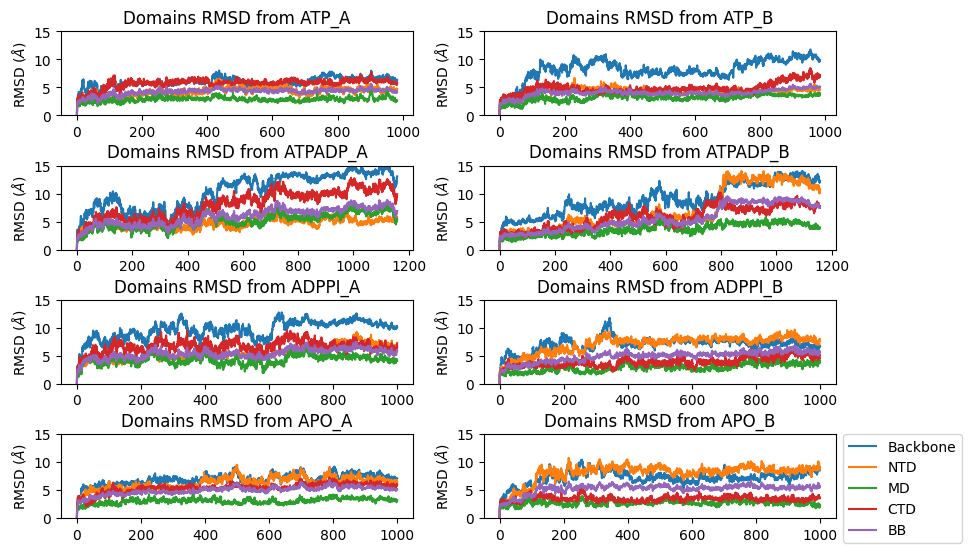

In [13]:
plt.figure(figsize=(10,10), dpi=100)
i = 0
while i < len(df_collection):
    plt.subplot(6,2,i+1)
    plt.plot(df_collection[i]['Time'], df_collection[i]['Backbone'], label='Backbone'),
    plt.plot(df_collection[i]['Time'], df_collection[i]['NTD'], label='NTD'),
    plt.plot(df_collection[i]['Time'], df_collection[i]['MD'], label="MD"), 
    plt.plot(df_collection[i]['Time'], df_collection[i]['CTD'], label='CTD'),
    plt.plot(df_collection[i]['Time'], df_collection[i]['BB'], label="BB")
    #plt.plot(df_collection[i]['Time'], df_collection[i]['PreN'], label="PreN")
    #plt.legend(loc="best")
    #plt.xlabel("Time (ns)")
    plt.ylabel(r'RMSD ($\AA$)')
    plt.ylim(0,15)
    plt.title('Domains RMSD from ' + name_collection[i])
    plt.subplots_adjust(hspace= 0.6)
    i= i+1
#plt.legend(loc="best")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

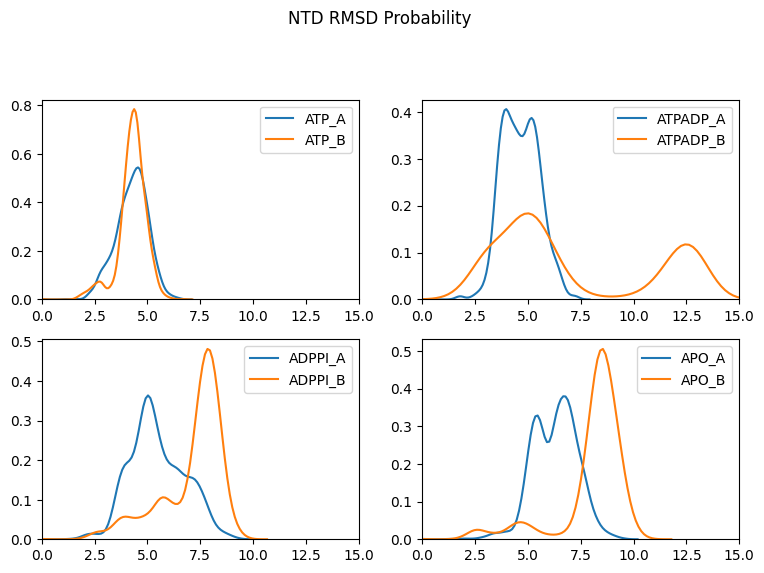

In [15]:
plt.figure(figsize=(9,9), dpi=100)
plt.suptitle ('NTD RMSD Probability')
plt.subplot(3,2,1)
sns.kdeplot(df_collection[0]['NTD'], label=name_collection[0])
sns.kdeplot(df_collection[1]['NTD'], label=name_collection[1])
plt.xlim(0,15)
plt.subplot(3,2,2)
sns.kdeplot(df_collection[2]['NTD'], label=name_collection[2])
sns.kdeplot(df_collection[3]['NTD'], label=name_collection[3])
plt.xlim(0,15)
plt.subplot(3,2,3)
sns.kdeplot(df_collection[4]['NTD'], label=name_collection[4])
sns.kdeplot(df_collection[5]['NTD'], label=name_collection[5])
plt.xlim(0,15)
plt.subplot(3,2,4)
sns.kdeplot(df_collection[6]['NTD'], label=name_collection[6])
sns.kdeplot(df_collection[7]['NTD'], label=name_collection[7])
plt.xlim(0,15)
#plt.subplot(3,2,5)
#sns.kdeplot(df_collection[8]['NTD'], label=name_collection[8])
#sns.kdeplot(df_collection[9]['NTD'], label=name_collection[9])
#plt.xlim(0,15)
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('ntdrmsdprob.png', dpi=300)

In [281]:
# Rmsd per protein structure # Argon Nomenclature
NTD = 'backbone and resid 87-280'
CHA = 'backbone and resid 281-337'
MD = 'backbone and resid 338-593'
CTD = 'backbone and resid 594-747'
BB = 'backbone and not resid 281-337'
proA = 'backbone and segid PROA'
proB = 'backbone and segid PROB'
LID = 'backbone and resid 172-191'

In [283]:
#rmsd of different domains
#uni = {'ANP': u, 'ATPADP' : u1 , 'ADPPI' : u2, 'ATP': u3, 'APO': u4}
df_collection1 = []
for key, value in uni.items(): 
    R = rms.RMSD(value,  # universe to align
                   value,  # reference universe or atomgroup
                   select='backbone',  # group to superimpose and calculate RMSD
                   groupselections=[NTD, MD, CTD, BB, LID],  # groups for RMSD
                   ref_frame=0)  # frame index of the reference
    R.run()
    df = pd.DataFrame(R.rmsd,
                  columns=['Frame','Time (ns)','Backbone', 'NTD', 'MD', 'CTD', 'BB', 'LID'])
    df['Time'] = df['Frame']* 0.5
    #df = df.loc[df['Backbone'] < 40] #cuts off fames enthat ters the PBC image box
    df_collection1.append(df)

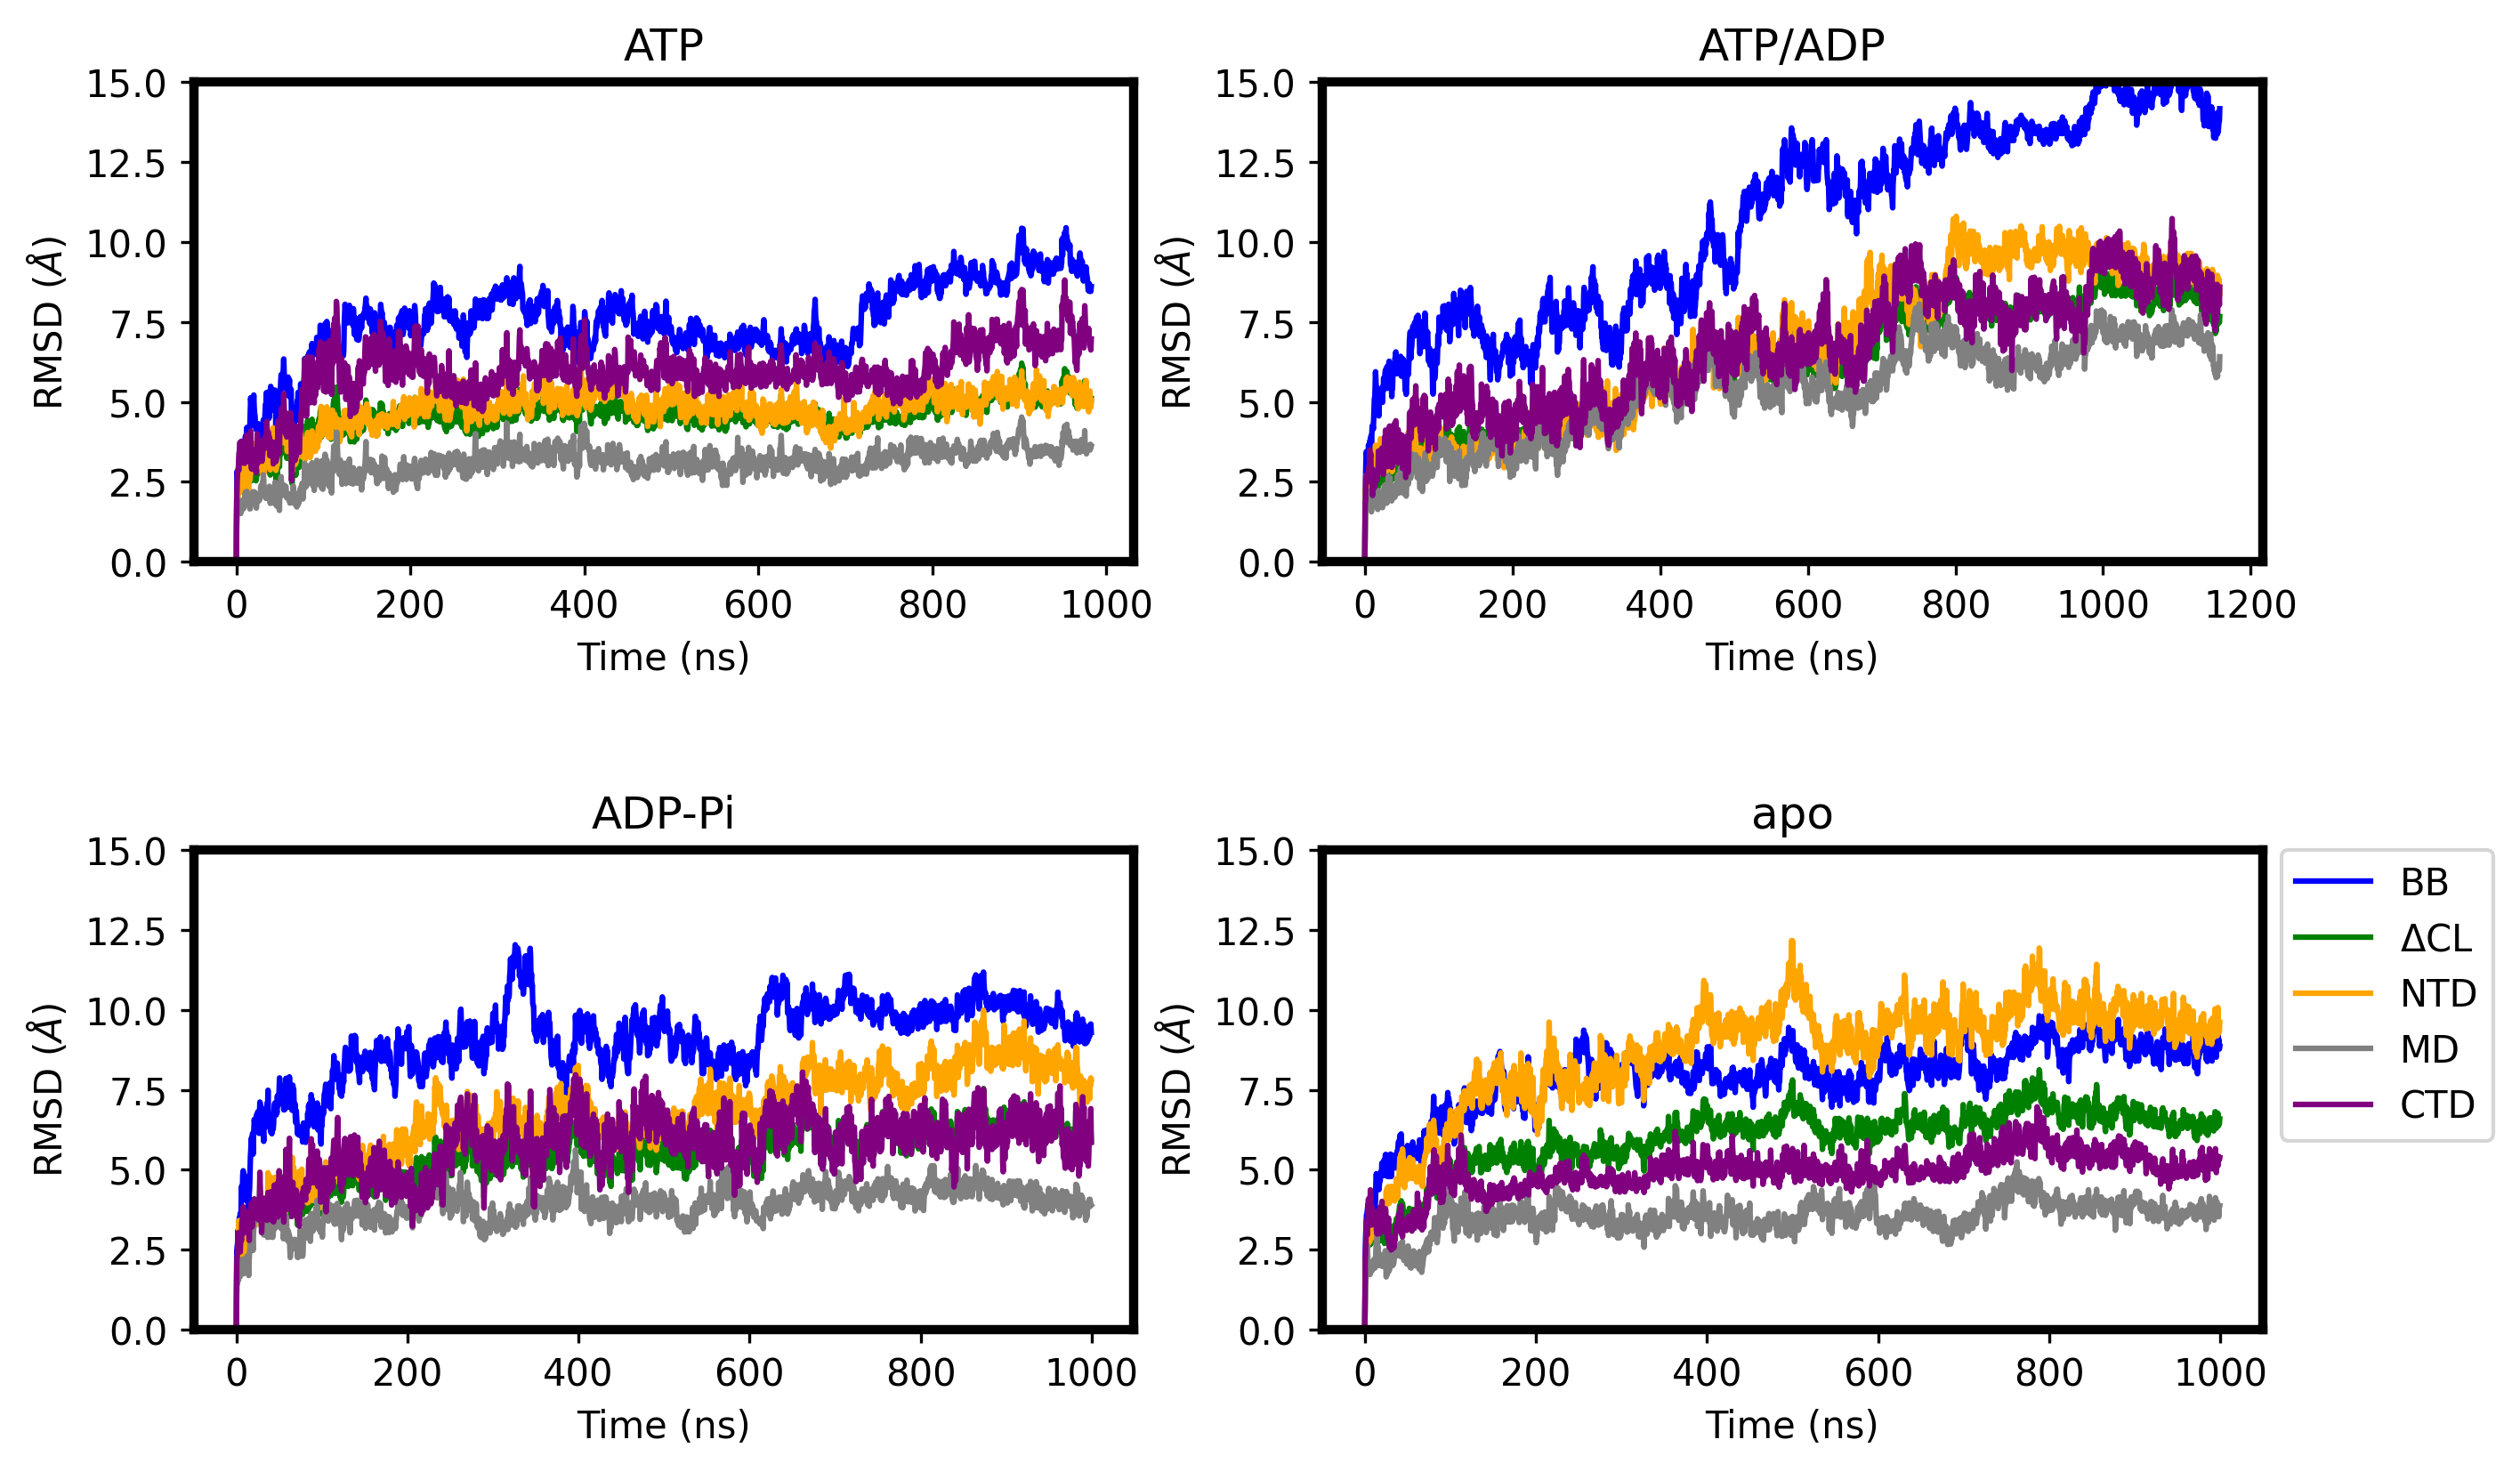

In [284]:
plt.figure(figsize=(10,10), dpi=300)
#name_collection1 = ["ATP","ATPADP",'ADPPI','APO']
i = 0
while i < len(df_collection1):
    plt.subplot(3,2,i+1)
    #df_collection1[i].plot( x= 'Time', y= ['Backbone', 'NTD', 'MD', 'CTD', 'nocha'] )
    plt.plot(df_collection1[i]['Time'], df_collection1[i]['Backbone'], label='BB', color='blue' ),
    plt.plot(df_collection1[i]['Time'], df_collection1[i]['BB'], label="$\Delta$CL", color="green")
    plt.plot(df_collection1[i]['Time'], df_collection1[i]['NTD'], label='NTD', color= 'orange'),
    plt.plot(df_collection1[i]['Time'], df_collection1[i]['MD'], label="MD", color = 'grey'),
    #plt.plot(df_collection1[i]['Time'], df_collection1[i]['M2'], label="M2"),
    plt.plot(df_collection1[i]['Time'], df_collection1[i]['CTD'], label='CTD', color='purple'),
    
    
    plt.xlabel("Time (ns)")
    plt.ylabel(r'RMSD ($\AA$)')
    plt.ylim(0,15)
    plt.title( name_collection1[i])

    plt.subplots_adjust(hspace= 0.6)
    i= i+1
#plt.legend()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('/home/alaooj/namd/5uls/rmsd.png')
plt.show()

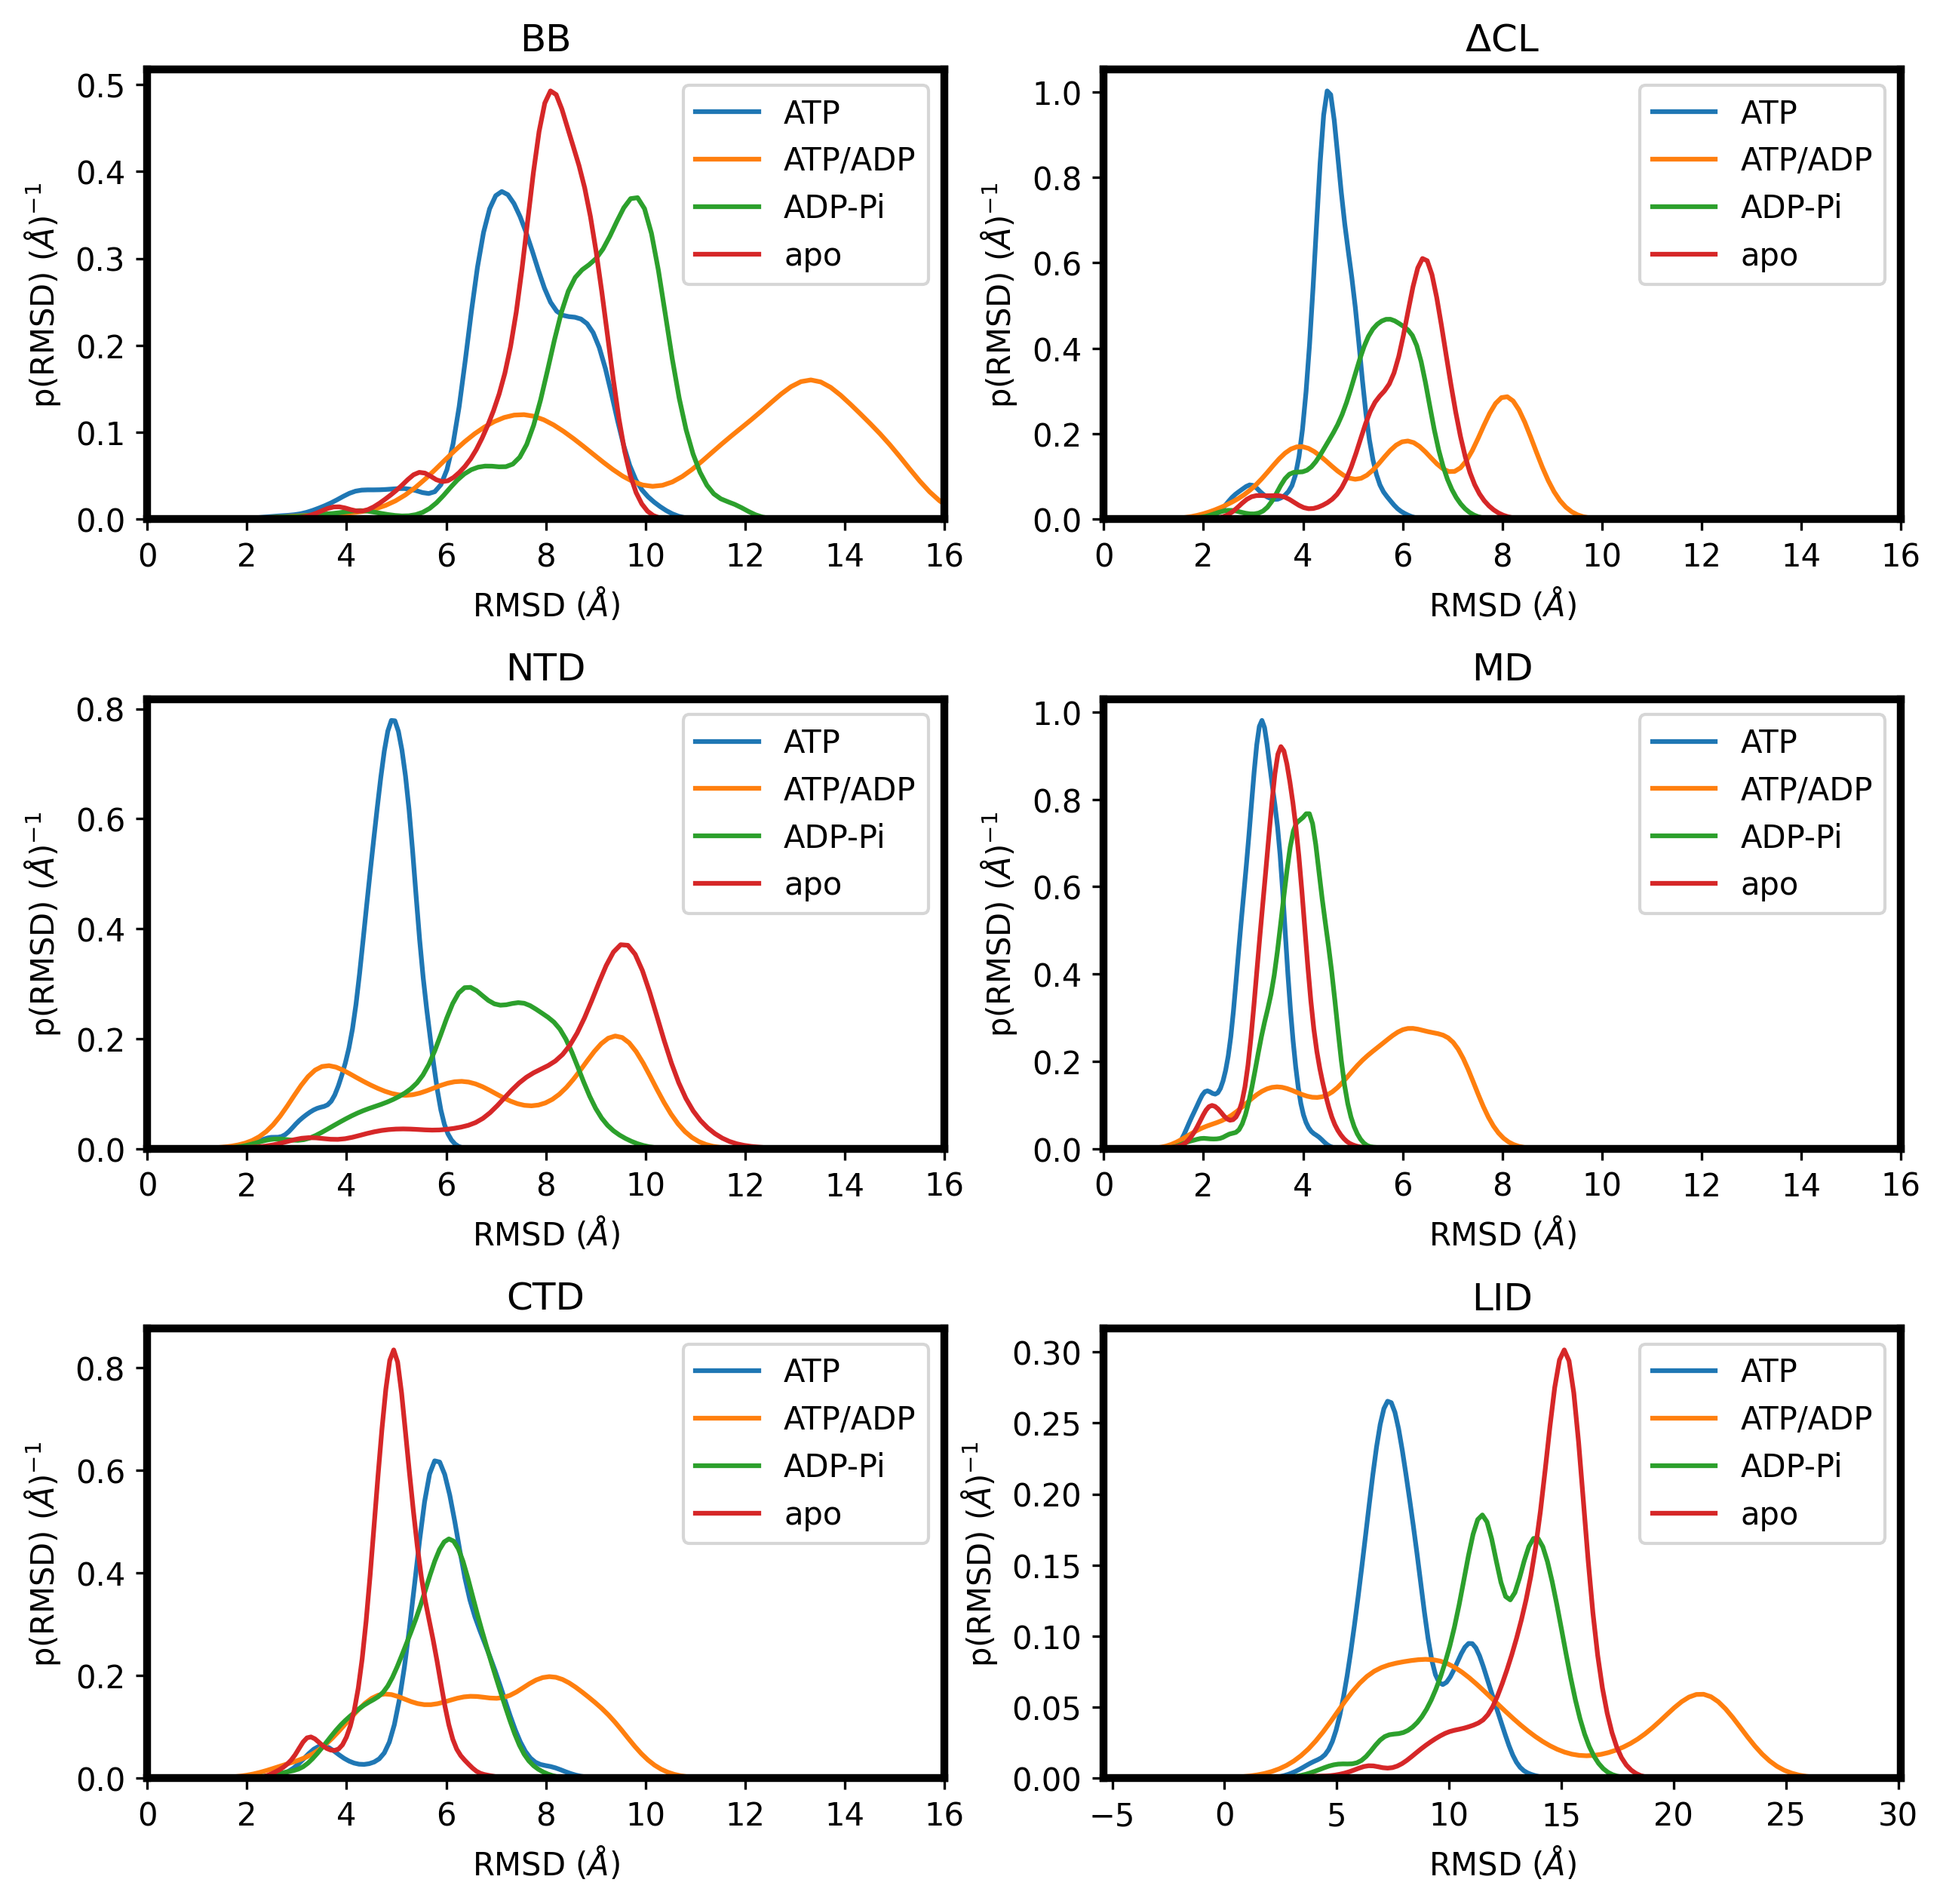

In [286]:
#plot rmsd
plt.figure(figsize=(10,10), dpi=300)
#name_collection1 = ["ANP","ATPADP",'ADPPI','ATP','APO']
i = 0
while i < len(df_collection1):
    #ax = df_collection1[i].plot( x= 'Time (ns)', y= ['Backbone', 'NTD', 'MD', 'CTD', 'nocha'] )
    plt.subplot(3,2,1)
    #df_collection1[i].plot( x= 'Time', y= ['Backbone', 'NTD', 'MD', 'CTD', 'nocha'] )
    sns.kdeplot(df_collection1[i]['Backbone'], label=name_collection1[i]),
    plt.title('BB') # + name_collection[i])
    plt.ylabel("p(RMSD) ($\AA)^{-1}$")
    plt.xlabel("RMSD ($\AA$)")
    plt.xlim(0,16)
    #plt.title('NTD RMSD') # + name_collection[i])
    plt.subplot(3,2,2)
    sns.kdeplot(df_collection1[i]['BB'], label=name_collection1[i]),
    plt.title('$\Delta$CL') # + name_collection[i])
    #plt.title('NOCHA RMSD') # + name_collection[i])
    plt.ylabel("p(RMSD) ($\AA)^{-1}$")
    plt.xlabel("RMSD ($\AA$)")
    plt.xlim(0,16)
    plt.subplot(3,2,3)
    sns.kdeplot(df_collection1[i]['NTD'], label=name_collection1[i]),
    plt.title('NTD') # + name_collection[i])
    #plt.title('NOCHA RMSD') # + name_collection[i])
    plt.ylabel("p(RMSD) ($\AA)^{-1}$")
    plt.xlabel("RMSD ($\AA$)")
    plt.xlim(0,16)
    plt.subplot(3,2,4)
    sns.kdeplot(df_collection1[i]['MD'], label=name_collection1[i]),
    plt.title('MD') # + name_collection[i])
    #plt.title('NOCHA RMSD') # + name_collection[i])
    plt.ylabel("p(RMSD) ($\AA)^{-1}$")
    plt.xlabel("RMSD ($\AA$)")
    plt.xlim(0,16)
    plt.subplot(3,2,5)
    sns.kdeplot(df_collection1[i]['CTD'], label=name_collection1[i]),
    plt.title('CTD') # + name_collection[i])
    plt.ylabel("p(RMSD) ($\AA)^{-1}$")
    plt.xlabel("RMSD ($\AA$)")
    plt.xlim(0,16)
    plt.subplot(3,2,6)
    sns.kdeplot(df_collection1[i]['LID'], label=name_collection1[i]),
    plt.title('LID') # + name_collection[i])
    plt.ylabel("p(RMSD) ($\AA)^{-1}$")
    plt.xlabel("RMSD ($\AA$)")
   # plt.xlim(0,16)
    plt.subplots_adjust(hspace= 0.4)
    #plt.legend(loc="best")
    i= i+1
#plt.legend()
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('rmsdprb.png', dpi=300)


# Radius of Gyration

In [8]:
#uni = {'ANP': u, 'ATPADP' : u1, 'ADPPI' : u2, 'ATP': u3, 'APO': u4}

Rg_collection = []
for key, value in uni.items():
    Rgyr = []
 #protein = u.select_atoms("resid 87-265  and name CA")
    protein = value.select_atoms("not resid 287-337")
    for ts in value.trajectory:
        Rgyr.append((value.trajectory.time, protein.radius_of_gyration()))
    Rgyr = np.array(Rgyr)
    Rg = pd.DataFrame(Rgyr,
                  columns=['Time','Rgyr'])
    Rg = Rg.round(2)
    Rg_collection.append(Rg)


In [9]:
name = ["ATP", "ATPADP",'ADPPI','APO']
i=0
while i < len(Rg_collection):
    
    print("Rg of {0} \n Mean = {1} \n Std = {2} \n Max ={3} \n Min = {4}".format(name[i], Rg_collection[i]['Rgyr'].mean(),
    Rg_collection[i]['Rgyr'].std(), Rg_collection[i]['Rgyr'].max(), Rg_collection[i]['Rgyr'].min(), Rg_collection[i]['Rgyr'].mode()))
    
    i+=1

Rg of ATP 
 Mean = 70.35176410777845 
 Std = 0.051773130509280445 
 Max =70.54 
 Min = 70.22
Rg of ATPADP 
 Mean = 70.47885196374644 
 Std = 0.1572254388170419 
 Max =70.97 
 Min = 70.23
Rg of ADPPI 
 Mean = 70.34703499999993 
 Std = 0.07276266884872327 
 Max =70.7 
 Min = 70.19
Rg of APO 
 Mean = 1076.5558500000009 
 Std = 377.69565137410734 
 Max =1612.34 
 Min = 70.31


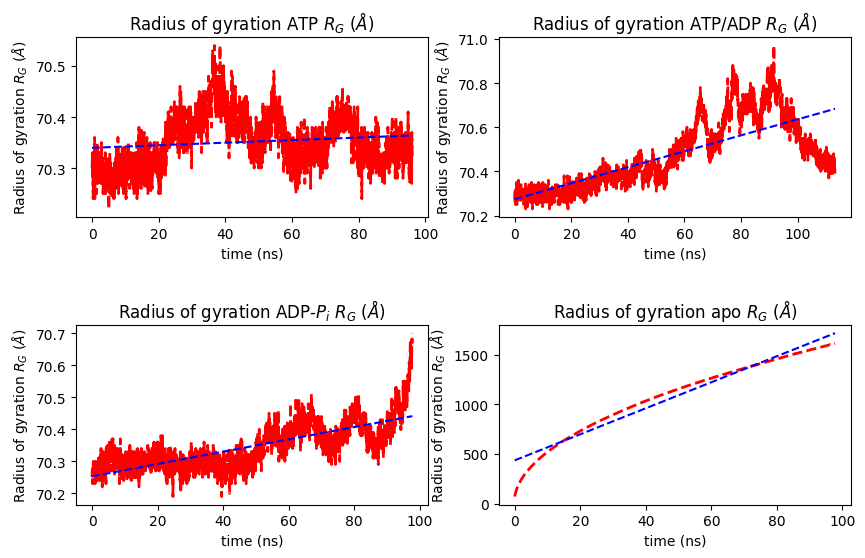

In [11]:
#df = df.loc[df['Backbone'] < 40]
plt.figure(figsize=(10,10), dpi=100)
i = 0
while i < len(Rg_collection):
    plt.subplot(3,2,i+1)
    x= Rg_collection[i]['Time']
    y= Rg_collection[i]['Rgyr']
    #y= Rg_collection[i].loc[Rg_collection[i]['Rgyr']<42]
    #plt.plot(Rg_collection[i]['Time (ns)'], Rg_collection[i]['Rgyr'], 'r--', lw=2, label=r"$R_G$")
    plt.plot(x,y, 'r--', lw=2, label=r"$R_G$")
    #cal and plot trend line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"b--")
    plt.xlabel("time (ns)")
    plt.ylabel(r"Radius of gyration $R_G$ ($\AA$)")
    plt.title(r"Radius of gyration {} $R_G$ ($\AA$)".format(name_collection1[i]))
    #ax.figure.savefig("Rgyr.pdf")
   # plt.ylim([38,44])
    plt.subplots_adjust(hspace= 0.6)
    i= i+1

# RMSF

In [6]:
unin = {'atp': u, 'adpatp' : u1, 'adppi' : u2, 'apo': u3}
#nuc= ['anp', 'adpatp', 'adppi', 'atp', 'apo']
rf_collection = []
for key, value in unin.items():
    
    protein = value.select_atoms("protein")
    
    average = align.AverageStructure(value, value, select='protein and name CA',
                                 ref_frame=0).run()
    ref = average.universe



# # #Align to ref
#     aligner = align.AlignTraj(value, ref,
#                               select='protein and name CA',
#                               in_memory=True).run()

## Align without using in memory
    aligner = align.AlignTraj(value, ref,
                          select='protein and name CA',
                          filename='aligned_traj.dcd',
                          in_memory=False).run()
    value = mda.Universe('5uls-{0}/prep/namd/step3_charmm2namd.psf'.format(key.lower()), 'aligned_traj.dcd')

    c_alphas = value.select_atoms('protein and name CA')
    R = rms.RMSF(c_alphas).run()
    
    rf=pd.DataFrame(c_alphas.resids)
    rf['rmsf'] = R.rmsf
    rf_collection.append(rf)
    rf.to_csv(key + '_rmsf.dat',  index = False)
    #c_alphas.atoms.write('CA_{0}.pdb'.format(key))
    value.add_TopologyAttr('tempfactors') # add empty attribute for all atoms
    protein = value.select_atoms('protein') # select protein atoms
    for residue, r_value in zip(protein.residues, R.rmsf):
        residue.atoms.tempfactors = r_value
        #u.atoms.write('anprmsf_tempfactors.pdb')
    value.select_atoms('protein and name CA').atoms.write('{0}_ca.pdb'.format(key))   
    #view = nv.show_mdanalysis(protein)
#   view = nv.show_mdanalysis(c_alphas)
    #view.update_representation(color_scheme='bfactor')
   # 'view_{0}'.format(key).update_representation(color_scheme='bfactor')
    #view

In [33]:
warnings.filterwarnings('ignore')
#%matplotlib inline
%matplotlib notebook
#import mpld3
#mpld3.enable_notebook()

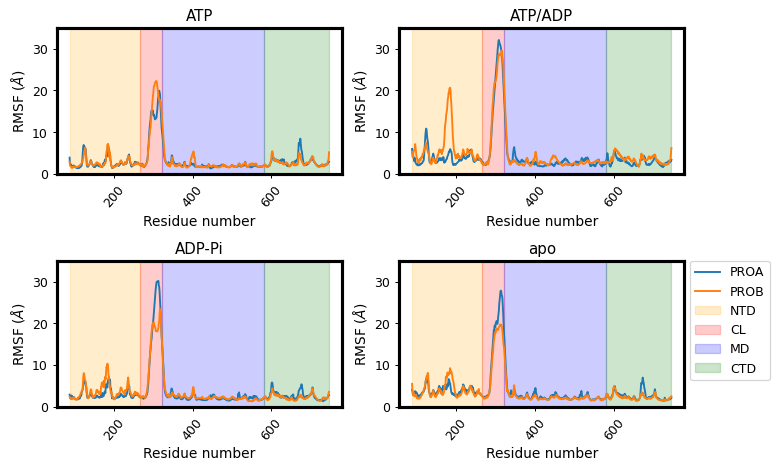

In [275]:
plt.figure(figsize=(9,9), dpi=90)
#name_collection = ["ANP","ATPADP",'ADPPI','ATP','APO']
i = 0
while i < len(rf_collection):
    plt.subplot(3,2,i+1)
    plt.plot(rf_collection[i][0:661][0], rf_collection[i][0:661]['rmsf'], label='PROA')
    plt.plot(rf_collection[i][661:1322][0], rf_collection[i][661:1322]['rmsf'], label='PROB')
    plt.xlabel('Residue number', fontsize=11)
    plt.ylabel('RMSF ($\AA$)', fontsize=11)
    plt.axvspan(87, 265, zorder=0, alpha=0.2, color='orange', label='NTD')
    plt.axvspan(265,321, zorder=0, alpha=0.2, color='red', label='CL')
    plt.axvspan(322, 581, zorder=0, alpha=0.2, color='blue', label='MD')
    plt.axvspan(581, 747, zorder=0, alpha=0.2, color='green', label='CTD')
    plt.title( name_collection1[i], fontsize=12)
    plt.xticks(rotation=50, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.ylim(0,35)
    plt.subplots_adjust(hspace= 0.6)
    #plt.legend();
    i= i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)   
plt.savefig('rmsfpernuc.png', dpi=300)

In [ ]:
pd = rf_collection[0]
#pd.iloc[:][] 

pd = pd.loc[pd['rmsf'].between(4, 10)]
pd

# ligand rmsd

In [205]:
lig1 = '(segid LIG1 or segid HETD) and not (name H*)' 
lig2 = 'segid LIG2 or segid HETE and not name H*'

In [206]:
unilig = { 'ATP' : u, 'ATPADP' : u1 , 'ADPPI' : u2, } # 'APO': u4}
#uni = { 'ANP' : u}
lg_collection = []  #rmsd lig1
lg_collection2 = [] #rmsd lig2
# cal rmsd for lig1
for key, value in unilig.items(): 
    if key== "ANP":
        lig1 = '(segid HETD ) and not (name H* O1G O2G O3G PG)' 
        lig2 = '(segid HETE ) and not (name H* O1G O2G O3G PG)'
    elif key == "ATPADP":
        lig1 = '(segid LIG1 ) and not (name H* O1G O2G O3G PG)' 
        lig2 = '(segid LIG2 ) and not (name H* O1 O2 O3 O14 P1)'
    elif key == 'ADPPI':
        lig1 = '(segid LIG1 ) and not (name H* O1 O2 O3 O14 P1)' 
        lig2 = '(segid LIG2 ) and not (name H* O1 O2 O3 O14 P1)'
    elif key == "ATP":
        lig1 = '(segid HETD ) and not (name H* O1G O2G O3G PG)' 
        lig2 = '(segid HETE ) and not (name H* O1G O2G O3G PG)'   
    else:
        print("no valid selection")
        
    R = rms.RMSD(value,  # universe to align
                   value,  # reference universe or atomgroup
                   #select='backbone',  # group to superimpose and calculate RMSD
                   select=lig1,
                   groupselections=[lig1],  # groups for RMSD
                   ref_frame=0)  # frame index of the reference
    #print('lig1 {0} = {1}'.format(key, lig1))
    #Print out residues selected
    sele1= value.select_atoms(lig1)
    sele2 = value.select_atoms(lig2)
    n_sele1 = len(sele1)
    n_sele2 = len(sele2)
    print('Sele1 has {} residues and Sele2 has {} residues {} '.format(n_sele1, n_sele2, key))
    
    R.run()
    lg = pd.DataFrame(R.rmsd,
                  columns=['Frame','Time (ns)','Backbone', 'lig1'])
    lg['Time'] = lg['Frame']* .5
    #lg = lg.loc[lg['Backbone'] < 40] #cuts off fames enthat ters the PBC image box
   
    lg_collection.append(lg)
#cal rmsd for lig 2  
#for key, value in uni.items(): 
    R2 = rms.RMSD(value,  # universe to align
                   value,  # reference universe or atomgroup
                   #select='backbone',  # group to superimpose and calculate RMSD
                   select=lig2,
                   groupselections=[lig2],  # groups for RMSD
                   ref_frame=0)  # frame index of the reference
    R2.run()
    lg2 = pd.DataFrame(R2.rmsd,
                  columns=['Frame','Time (ns)','Backbone', 'lig2'])
    lg2['Time'] = lg2['Frame']* .5
    #lg = lg.loc[lg['Backbone'] < 40] #cuts off fames enthat ters the PBC image box
    lg_collection2.append(lg2)

Sele1 has 27 residues and Sele2 has 27 residues ATP 
Sele1 has 27 residues and Sele2 has 27 residues ATPADP 
Sele1 has 27 residues and Sele2 has 27 residues ADPPI 


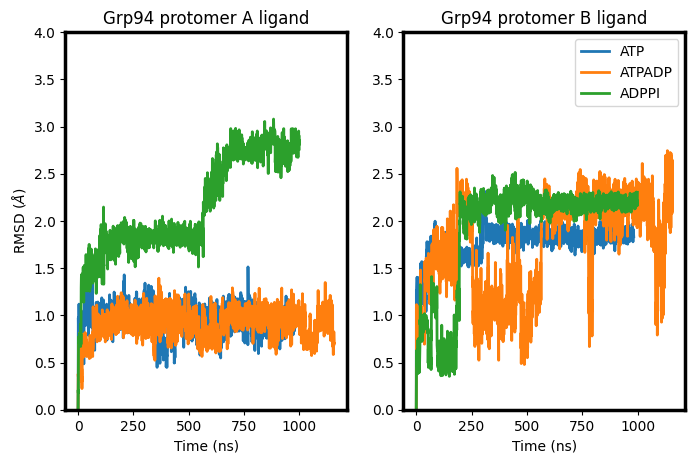

In [254]:
fig = plt.figure(figsize=(8,5), dpi=100)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
name_collection = ["ATP","ATPADP",'ADPPI'] #,'APO']
i = 0
while i < len(lg_collection):
    ax1.plot(lg_collection[i]['Time'], lg_collection[i]['lig1'],  lw=2,  label='{0}'.format(name_collection[i])),
    ax2.plot(lg_collection2[i]['Time'], lg_collection2[i]['lig2'],  lw=2, label='{0}'.format(name_collection[i])), 
    plt.legend()
    ax1.set_xlabel("Time (ns)")
    ax2.set_xlabel("Time (ns)")
    ax1.set_ylabel(r'RMSD ($\AA$)')
    ax1.set_ylim(0,4)
    ax2.set_ylim(0,4)
    ax1.set_title('Grp94 protomer A ligand')
    ax2.set_title('Grp94 protomer B ligand')
    i= i+1
plt.legend()
plt.savefig('ligrmsd.png', dpi=300)
plt.show()

# Distance between lig1 resid 448 and chain A

In [45]:
#chain A
unilig = {'ATP': u, 'ATPADP' : u1, 'ADPPI' : u2, }#'APO': u3}
dist_collection = []
distB_collection = []
for key, value in unilig.items():
    
    if key== "ANP":
        lig1 = '(segid HETD ) and not (name H* O1G O2G O3G PG)' 
        lig2 = '(segid HETE ) and not (name H* O1G O2G O3G PG)'
    elif key == "ATPADP":
        lig1 = '(segid LIG1 ) and not (name H* O1G O2G O3G PG)' 
        lig2 = '(segid LIG2 ) and not (name H* O1 O2 O3 O14 P1)'
    elif key == 'ADPPI':
        lig1 = '(segid LIG1 ) and not (name H* O1 O2 O3 O14 P1)' 
        lig2 = '(segid LIG2 ) and not (name H* O1 O2 O3 O14 P1)'
    elif key == "ATP":
        lig1 = '(segid HETD ) and not (name H* O1G O2G O3G PG)' 
        lig2 = '(segid HETE ) and not (name H* O1G O2G O3G PG)'   
    else:
        print("no valid selection")
        
    #sele1= value.select_atoms('(segid HETD and (name PA or name PB)) or (segid LIG1 and (name PA or name PB)) or (segid LIG1 and (name P1 or name P2))')
    #sele2 = value.select_atoms('segid PROA and resid 448')
    sele1= value.select_atoms(lig1)
    sele2 = value.select_atoms('segid PROA and resid 448')
    n_sele1 = len(sele1)
    n_sele2 = len(sele2)
    print('Sele1 has {} residues and Sele2 has {} residues'.format(n_sele1, n_sele2))
    dis = []
    for ts in value.trajectory:
        dist_arr = distances.distance_array(sele1.positions, # reference
                                    sele2.positions, # configuration
                                    box=value.dimensions)
        dis.append((ts.frame, dist_arr[0][0])) #this extract the values out of [[]]
#dist = np.array(dist)
    dist = pd.DataFrame(dis,
                  columns=['frame','dist'])
    dist_collection.append(dist)
    
#for key, value in uni.items():
    #sele1= value.select_atoms('(segid HETE and (name PA or name PB)) or (segid LIG2 and (name PA or name PB)) or (segid LIG2 and (name P1 or name P2))')
    sele1= value.select_atoms(lig2)
    sele2 = value.select_atoms('segid PROB and resid 448')
    n_sele1 = len(sele1)
    n_sele2 = len(sele2)
    print('2Sele1 has {} residues and 2Sele2 has {} residues in chainB {} '.format(n_sele1, n_sele2, key))
    dis = []
    for ts in value.trajectory:
        dist_arr = distances.distance_array(sele1.positions, # reference
                                    sele2.positions, # configuration
                                    box=value.dimensions)
        dis.append((ts.frame, dist_arr[0][0])) #this extract the values out of [[]]
#dist = np.array(dist)
    dist = pd.DataFrame(dis,
                  columns=['frame','dist'])
    distB_collection.append(dist)

Sele1 has 27 residues and Sele2 has 24 residues
2Sele1 has 27 residues and 2Sele2 has 24 residues in chainB ATP 
Sele1 has 27 residues and Sele2 has 24 residues
2Sele1 has 27 residues and 2Sele2 has 24 residues in chainB ATPADP 
Sele1 has 27 residues and Sele2 has 24 residues
2Sele1 has 27 residues and 2Sele2 has 24 residues in chainB ADPPI 


<IPython.core.display.Javascript object>


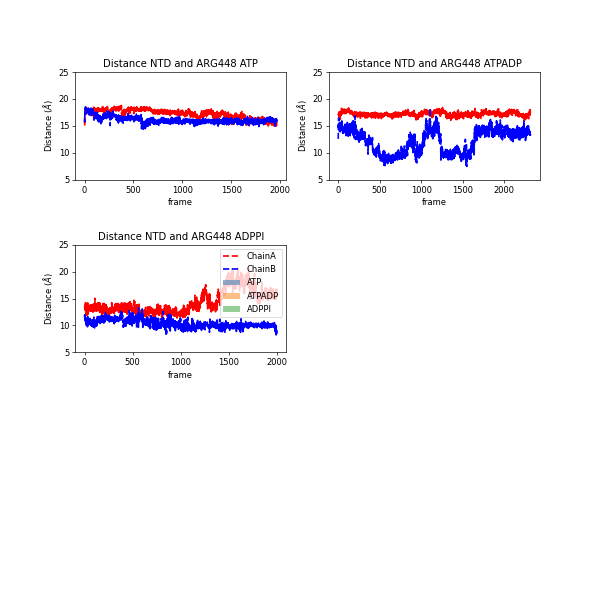

In [51]:
plt.figure(figsize=(10,10), dpi=90)
#name_collection = ["ATP","ATPADP",'ADPPI','APO']
i = 0
while i < len(dist_collection):
    #ax = df_collection[i].plot( x= 'Time (ns)', y= ['Backbone', 'NTD', 'MD', 'CTD', 'nocha'] )
    #plt.subplot(3,2,i+1)
    ax = plt.subplot(3,2,i+1)
    #df_collection[i].plot( x= 'Time (ns)', y= ['Backbone', 'NTD', 'MD', 'CTD', 'nocha'] )
    ax.plot(dist_collection[i]['frame'], dist_collection[i]['dist'],'r--', lw=2, label=r"ChainA" ),
    ax.plot(distB_collection[i]['frame'], distB_collection[i]['dist'], 'b--', lw=2, label=r"ChainB"),
    #ax.plot(dist_collection[i]['frame'], df_collection[i]['nocha'])
    plt.xlabel("frame")
    plt.ylabel(r'Distance ($\AA$)')
    plt.ylim(5,25)
    plt.title('Distance NTD and ARG448 ' + name_collection1[i])
    plt.subplots_adjust(hspace= 0.6)
    i= i+1
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


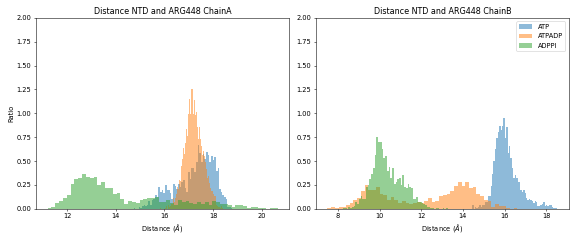

In [49]:
#Express distance above as histogram
#plt.figure(figsize=(10,10), dpi=100)

#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
i = 0
while i < len(dist_collection):
#ax.plot(dist_collection[i]['frame'], dist_collection[i]['dist']),
    ax1.hist(dist_collection[i]['dist'], bins = 60, density=True, alpha=0.5, label=name_collection1[i]) #Hist plot
    ax2.hist(distB_collection[i]['dist'], bins = 60, density=True, alpha=0.5, label=name_collection1[i])
    #sns.kdeplot(value.dist, label=key) # line trace plot
    ax1.set_ylabel("Ratio")
    ax1.set_xlabel(r'Distance ($\AA$)')
    ax2.set_xlabel(r'Distance ($\AA$)')
    ax1.set_ylim(0,2)
    ax2.set_ylim(0,2)
    
    ax1.set_title('Distance NTD and ARG448 ChainA') # + name_collection1[i])
    ax2.set_title('Distance NTD and ARG448 ChainB')
    plt.subplots_adjust(hspace= 0.6)
    fig.tight_layout()
    i= i+1  
plt.legend()
plt.show()

#plt.hist(distance.dist, bins = 60, density=True, alpha=0.5, )#label=key)
#plt.show()

In [52]:
#distance between lig1 resid 448 and chain A #vmd
ATP = pd.read_csv('5uls-atp/prep/namd/dist.dat', header=None)
ATPADP = pd.read_csv('5uls-adpatp/prep/namd/dist.dat', header=None)
ADPPI = pd.read_csv('5uls-adppi/prep/namd/dist.dat', header=None)

cols = {'ATP': ATP, 'ATPADP' : ATPADP, 'ADPPI' : ADPPI }

for key, value in cols.items():
    value.columns = ['frame', 'dist']
    value["Time"] = value['frame'] *0.2
    #plt.plot(value.Time, value.dist, label=key) #line plot
    plt.hist(value.dist, bins = 60, density=True, alpha=0.5, label=key) #Hist plot
    #sns.kdeplot(value.dist, label=key) # line trace plot
plt.legend()
plt.show()

# Distance between Glu103 and Arg448

In [53]:
#uni = {'ANP': u, 'ATPADP' : u1, 'ADPPI' : u2, 'ATP': u3, 'APO': u4}
dist1_collection = []
for key, value in uni.items():
    sele1= value.select_atoms('segid PROA and resid 103 and name CA')
    sele2 = value.select_atoms('segid PROA and resid 448 and name CA')
    n_sele1 = len(sele1)
    n_sele2 = len(sele2)
    print('Sele1 has {} residues and Sele2 has {} residues in chainB {} '.format(n_sele1, n_sele2, key))
    dis = []
    for ts in value.trajectory:
        dist_arr = distances.distance_array(sele1.positions, # reference
                                    sele2.positions, # configuration
                                    box=value.dimensions)
        dis.append((ts.frame, dist_arr[0][0])) #this extract the values out of [[]]
#dist = np.array(dist)
    dist = pd.DataFrame(dis,
                  columns=['frame','dist'])
    dist1_collection.append(dist)
#distance.head(5)

Sele1 has 1 residues and Sele2 has 1 residues in chainB ATP 
Sele1 has 1 residues and Sele2 has 1 residues in chainB ATPADP 
Sele1 has 1 residues and Sele2 has 1 residues in chainB ADPPI 
Sele1 has 1 residues and Sele2 has 1 residues in chainB APO 


<IPython.core.display.Javascript object>


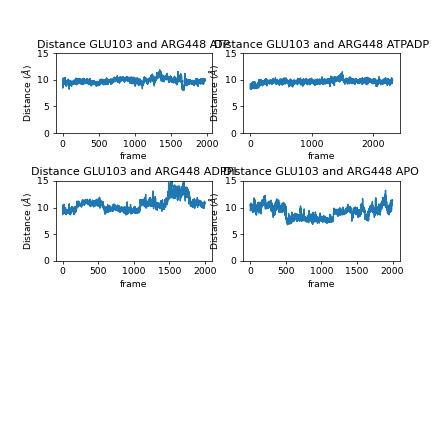

In [54]:
plt.figure(figsize=(10,10), dpi=100)
#name_collection = ["ANP","ATPADP",'ADPPI','ATP','APO']
i = 0
while i < len(dist1_collection):
    ax = plt.subplot(3,2,i+1)
    #df_collection[i].plot( x= 'Time (ns)', y= ['Backbone', 'NTD', 'MD', 'CTD', 'nocha'] )
    ax.plot(dist1_collection[i]['frame'], dist1_collection[i]['dist']),
    #ax.plot(dist_collection[i]['frame'], df_collection[i]['CTD']),
    #ax.plot(dist_collection[i]['frame'], df_collection[i]['nocha'])
    plt.xlabel("frame")
    plt.ylabel(r'Distance ($\AA$)')
    plt.ylim(0,15)
    plt.title('Distance GLU103 and ARG448 ' + name_collection1[i])
    plt.subplots_adjust(hspace= 0.6)
    i= i+1

In [70]:
#plt.figure(figsize=(10,10), dpi=100)
#name_collection = ["ANP","ATPADP",'ADPPI','ATP','APO']

i = 0
#while i < 4:
while i < len(dist1_collection):
#ax.plot(dist_collection[i]['frame'], dist_collection[i]['dist']),
    plt.hist(dist1_collection[i]['dist'], bins = 60, density=True, alpha=0.5, label=name_collection1[i]) #Hist plot
    #sns.kdeplot(value.dist, label=key) # line trace plot
    plt.xlabel("frame")
    plt.ylabel(r'Distance ($\AA$)')
    plt.xlim(7,20)
    plt.title('Distance 103 and ARG448 ') # + name_collection1[i])
    plt.subplots_adjust(hspace= 0.6)
    i= i+1
plt.legend()
plt.show()

In [71]:
#dist 87-87 and 395-395
#uni = {'ANP': u, 'ATPADP' : u1, 'ADPPI' : u2, 'ATP': u3, 'APO': u4}
dist2_collection = []
for key, value in uni.items():
    sele1= value.select_atoms('name CA and segid PROA and (resid 87 or resid 395)')
    sele2 = value.select_atoms('name CA and segid PROB and (resid 87 or resid 395)')
    n_sele1 = len(sele1)
    n_sele2 = len(sele2)
    print('Sele1 has {} residues and Sele2 has {} residues in chainB {} '.format(n_sele1, n_sele2, key))
    dis = []
    for ts in value.trajectory:
        dist_arr = distances.distance_array(sele1.positions, # reference
                                    sele2.positions, # configuration
                                    box=value.dimensions)
        dis.append((ts.frame, dist_arr[0][0], dist_arr[1][1] )) #this extract the values 1,1 and 2,2
#dist = np.array(dist)
    dist = pd.DataFrame(dis,
                  columns=['frame','dist87', "dist395"])
    dist2_collection.append(dist)
dist.head(5)

Sele1 has 2 residues and Sele2 has 2 residues in chainB ATP 
Sele1 has 2 residues and Sele2 has 2 residues in chainB ATPADP 
Sele1 has 2 residues and Sele2 has 2 residues in chainB ADPPI 
Sele1 has 2 residues and Sele2 has 2 residues in chainB APO 


,frame,dist87,dist395
0,0,19.759809,33.603311
1,1,22.237669,34.153748
2,2,21.083599,33.776608
3,3,20.002688,34.207859
4,4,21.441008,34.128346


<IPython.core.display.Javascript object>


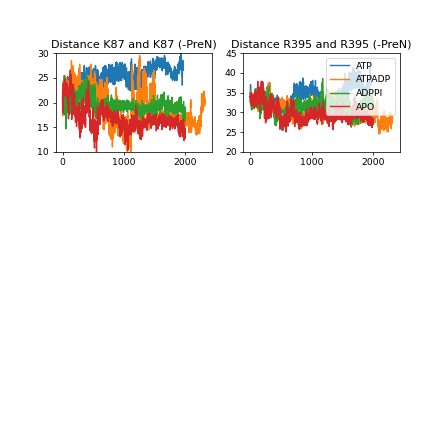

In [72]:
plt.figure(figsize=(10,10), dpi=100)
#name_collection = ["ANP","ATPADP",'ADPPI','ATP','APO']
i = 0
while i < len(dist2_collection):
    ax = plt.subplot(3,2,1)
    ax2 = plt.subplot(3,2,2)
    #df_collection[i].plot( x= 'Time (ns)', y= ['Backbone', 'NTD', 'MD', 'CTD', 'nocha'] )
    ax.plot(dist2_collection[i]['frame'], dist2_collection[i]['dist87'], label=name_collection1[i]),
    ax2.plot(dist2_collection[i]['frame'], dist2_collection[i]['dist395'], label=name_collection1[i])
    #ax.plot(dist_collection[i]['frame'], df_collection[i]['CTD']),
    #ax.plot(dist_collection[i]['frame'], df_collection[i]['nocha'])
    
    ax.set_ylim(10, 30)
    ax2.set_ylim(20, 45)
    ax.set_title('Distance K87 and K87 (-PreN)')
    ax2.set_title('Distance R395 and R395 (-PreN)')
    plt.legend(loc='best')
    #plt.subplots_adjust(hspace= 0.6)
    i= i+1

<IPython.core.display.Javascript object>


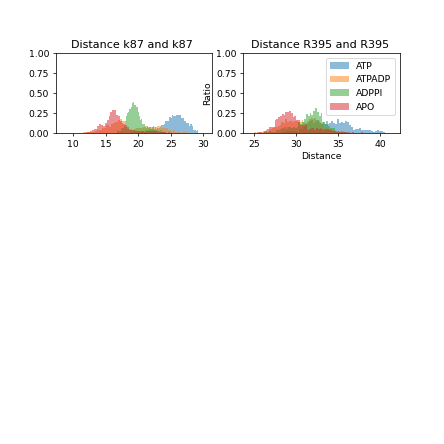

In [73]:
plt.figure(figsize=(10,10), dpi=100)
i = 0
#while i < 4:
while i < len(dist2_collection):
#ax.plot(dist_collection[i]['frame'], dist_collection[i]['dist']),
    ax = plt.subplot(3,2,1)
    ax2 = plt.subplot(3,2,2)
    ax.hist(dist2_collection[i]['dist87'], bins = 60, density=True, alpha=0.5, label=name_collection1[i]) #Hist plot
    ax2.hist(dist2_collection[i]['dist395'], bins = 60, density=True, alpha=0.5, label=name_collection1[i])
    #sns.kdeplot(value.dist, label=key) # line trace plot
    plt.xlabel("Distance")
    plt.ylabel(r'Ratio')
    ax.set_ylim(0, 1)
    ax2.set_ylim(0, 1)
    #plt.xlim(7,20)
    ax.set_title('Distance k87 and k87 ') # + name_collection[i])
    ax2.set_title('Distance R395 and R395 ')
    plt.subplots_adjust(hspace= 0.6)
    i= i+1
plt.legend()
plt.show()

# NTD Center of Mass calculation

In [151]:
dist3_collection = []
for key, value in uni.items():
    sele1= value.select_atoms(NTDA)
    sele2 = value.select_atoms(NTDB)
    sele3= value.select_atoms(MDA)
    sele4 = value.select_atoms(MDB)
    n_sele1 = len(sele1)
    n_sele2 = len(sele2)
    print('Sele1 has {} residues and Sele2 has {} residues in chainB {} '.format(n_sele1, n_sele2, key))
    dis = []
    for ts in value.trajectory:
        x=(sele1.center_of_mass())
        y=(sele2.center_of_mass())
        z=(norm((x) - (y)))
        
        p=(sele3.center_of_mass())
        q=(sele4.center_of_mass())
        j=(norm((p) - (q)))
        dis.append((ts.frame, z, j))
    dist = pd.DataFrame(dis,
                  columns=['frame','NTD diff', 'CTD diff'])
    dist3_collection.append(dist)
dist.head(5)


Sele1 has 2751 residues and Sele2 has 2751 residues in chainB ATP 
Sele1 has 2751 residues and Sele2 has 2751 residues in chainB ATPADP 
Sele1 has 2751 residues and Sele2 has 2751 residues in chainB ADPPI 
Sele1 has 2751 residues and Sele2 has 2751 residues in chainB APO 


,frame,NTD diff,CTD diff
0,0,41.369154,37.411230
1,1,41.143001,37.691804
2,2,39.795121,38.105170
3,3,40.666528,38.081333
4,4,40.850321,38.129881


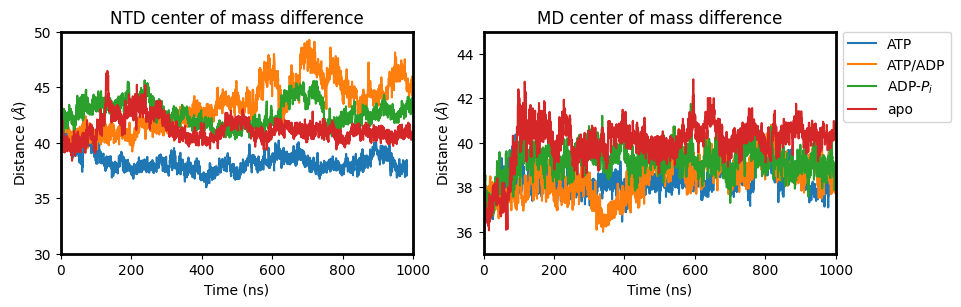

In [152]:
plt.figure(figsize=(10,10), dpi=100)
#name_collection = ["ANP","ATPADP",'ADPPI','ATP','APO']
i = 0
while i < len(dist3_collection):
    ax = plt.subplot(3,2,1)
    ax2 = plt.subplot(3,2,2)
    #df_collection[i].plot( x= 'Time (ns)', y= ['Backbone', 'NTD', 'MD', 'CTD', 'nocha'] )
    ax.plot(dist3_collection[i]['frame']/2, dist3_collection[i]['NTD diff'], label=name_collection1[i]),
    ax2.plot(dist3_collection[i]['frame']/2, dist3_collection[i]['CTD diff'], label=name_collection1[i])
    #ax.plot(dist_collection[i]['frame'], df_collection[i]['CTD']),
    #ax.plot(dist_collection[i]['frame'], df_collection[i]['nocha'])
    
    ax.set_ylim(30, 50)
    ax2.set_ylim(35, 45)
    ax.set_xlim(0,1000)
    ax2.set_xlim(0,1000)
    ax.set_title('NTD center of mass difference')
    ax2.set_title('MD center of mass difference')
    ax.set_ylabel(r'Distance ($\AA$)')
    ax2.set_ylabel(r'Distance ($\AA$)')
    ax.set_xlabel(r'Time (ns)')
    ax2.set_xlabel(r'Time (ns)')
    #plt.legend(loc='out')
    #plt.subplots_adjust(hspace= 0.6)
    i= i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('/home/kravatan/5uls/distnandc.png')
plt.show()

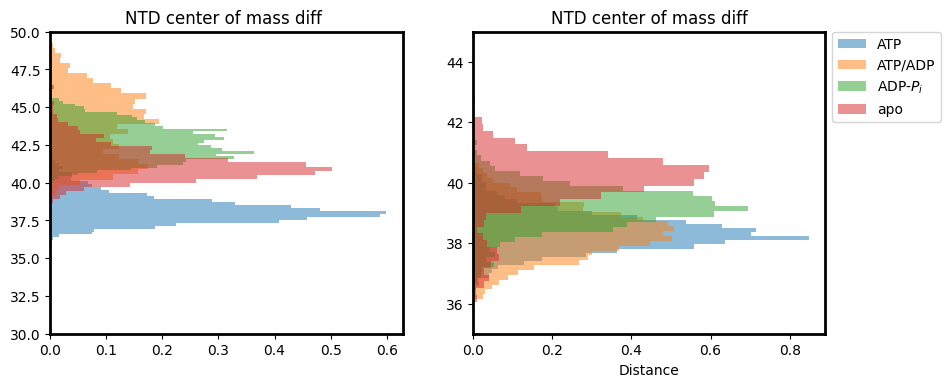

In [178]:
plt.figure(figsize=(10,4), dpi=100)
i = 0
while i < len(dist3_collection):
#ax.plot(dist_collection[i]['frame'], dist_collection[i]['dist']),
    ax = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    ax.hist(dist3_collection[i]['NTD diff'], bins = 30, density=True, orientation='horizontal', alpha=0.5, label=name_collection1[i]) #Hist plot
    ax2.hist(dist3_collection[i]['CTD diff'], bins = 30, density=True, orientation='horizontal', alpha=0.5, label=name_collection1[i])
    #sns.kdeplot(value.dist, label=key) # line trace plot
    plt.xlabel("Distance")
    #plt.ylabel(r'Ratio')
    #ax.set_ylim(0, 1)
    #ax2.set_ylim(0, 1)
    #plt.xlim(30,50)
    ax.set_ylim(30,50)
    ax2.set_ylim(35,45)
    ax2.yaxis.tick_left()
    #ax.set_ylim(ax.get_ylim()[::-1])
    #ax2.set_ylim(ax2.get_ylim()[::-1])
    ax.set_title('NTD center of mass diff ') # + name_collection[i])
    ax2.set_title('NTD center of mass diff')
    plt.subplots_adjust(hspace= 1.6)
    i= i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('/home/kravatan/5uls/prob-distnandc.png')
plt.show()

In [ ]:
Another way

In [144]:
NTDA = 'segid PROA and (resid 87-280) and not resid 171-191'
#CHAA = 'backbone and segid PROA and resid 281-337'
MDA = 'backbone and segid PROA and resid 338-593'
CTDA = 'segid PROA and resid 594-747'
BBA = 'backbone and segid PROA and not resid 281-337'
NTDB = 'segid PROB and (resid 87-280) and not resid 171-191' #note NTD starts from 74 for 5uls
#CHAB = 'backbone and segid PROB and resid 281-337'
MDB = 'backbone and segid PROB and resid 338-593'
CTDB = 'segid PROB and resid 594-747'
BBB = 'backbone and segid PROB and not resid 281-337'
proa = 'backbone and segid PROA'
prob = 'backbone and segid PROB'
PreNA = 'backbone and segid PROA and resid 22-73'
PreNB = 'backbone and segid PROA and resid 22-73'
dist3_collection = []
for key, value in uni.items():
    sele1= value.select_atoms(NTDA)
    sele2 = value.select_atoms(CTDA)
    sele3= value.select_atoms(NTDB)
    sele4 = value.select_atoms(CTDB)
    n_sele1 = len(sele1)
    n_sele2 = len(sele2)
    print('Sele1 has {} residues and Sele2 has {} residues in chainB {} '.format(n_sele1, n_sele2, key))
    dis = []
    for ts in value.trajectory:
        x=(sele1.center_of_mass())
        y=(sele2.center_of_mass())
        z=(norm((x) - (y)))
        p=(sele3.center_of_mass())
        q=(sele4.center_of_mass())
        j=(norm((p) - (q)))
        dis.append((ts.frame, z, j))
    dist = pd.DataFrame(dis,
                  columns=['frame','NTD diff', 'CTD diff'])
    dist3_collection.append(dist)
dist.head(5)

Sele1 has 2751 residues and Sele2 has 2510 residues in chainB ATP 
Sele1 has 2751 residues and Sele2 has 2510 residues in chainB ATPADP 
Sele1 has 2751 residues and Sele2 has 2510 residues in chainB ADPPI 
Sele1 has 2751 residues and Sele2 has 2510 residues in chainB APO 


,frame,NTD diff,CTD diff
0,0,80.951644,81.922315
1,1,81.324807,81.841805
2,2,82.347570,82.016927
3,3,81.945124,81.909912
4,4,83.071109,83.042567


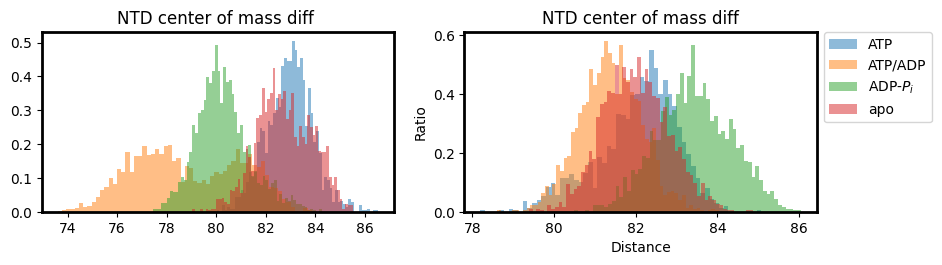

In [145]:
plt.figure(figsize=(10,10), dpi=100)
i = 0
while i < len(dist3_collection):
#ax.plot(dist_collection[i]['frame'], dist_collection[i]['dist']),
    ax = plt.subplot(3,2,1)
    ax2 = plt.subplot(3,2,2)
    ax.hist(dist3_collection[i]['NTD diff'], bins = 60, density=True, alpha=0.5, label=name_collection1[i]) #Hist plot
    ax2.hist(dist3_collection[i]['CTD diff'], bins = 60, density=True, alpha=0.5, label=name_collection1[i])
    #sns.kdeplot(value.dist, label=key) # line trace plot
    plt.xlabel("Distance")
    plt.ylabel(r'Ratio')
    #ax.set_ylim(0, 1)
    #ax2.set_ylim(0, 1)
    #plt.xlim(7,20)
    ax.set_title('NTD center of mass diff ') # + name_collection[i])
    ax2.set_title('NTD center of mass diff')
    plt.subplots_adjust(hspace= 0.6)
    i= i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# Residues around the NTD

In [ ]:
#unilig = {'ATP': u, 'ATPADP' : u1,  'ADPPI' : u2, } #'APO': u4}
s5A_collection = []
for key, value in unilig.items():
    sele = []
#seleA=u.select_atoms(" name CA and around 5 segid HETA", updating=True)
    for ts in value.trajectory[0:-1:4]:
        #u.residues
        seleA=value.select_atoms("name CA and around 5 segid HETD or segid LIG1 ", updating=True)
        seleB=value.select_atoms('name CA and around 5 segid HETE or segid LIG2', updating=True)
        sele.append((ts.frame, seleA.residues.resids, seleB.residues.resids))
    sele = np.array(sele)
    column_values = ['Frame' , 'LIG1', 'LIG2']
    df = pd.DataFrame(data = sele, columns = column_values)
    df['nucleotide'] = key
    print("done with" + key)
    #se = pd.DataFrame(sele,
                  #columns=['Time (ns)','Resids_chainA', 'Resids_chainB'])
    s5A_collection.append(df)

In [ ]:
df = pd.DataFrame(s5A_collection[0])
i = 1
while i < len(s5A_collection):
    df = pd.concat([df, s5A_collection[i]])
    i = i+1
df.to_csv('/home/alaooj/namd/5uls/resid_ntd1.csv', index = False)

# Another presentation using ditance of each NTD residues

In [ ]:

dist_collection = []
for key, value in unilig.items():
    sele1= value.select_atoms('(segid HETD and (name PA or name PB)) or (segid LIG1 and (name PA or name PB)) or (segid LIG1 and (name P1 or name P2))') #adp are name P1,P2,P3 while othera are PAPBPC
    sele2 = value.select_atoms('segid PROA and name CA and resid 49-265')
    n_sele1 = len(sele1)
    n_sele2 = len(sele2)
    print('Sele1 has {} residues and Sele2 has {} residues from {} '.format(n_sele1, n_sele2, key))
    dist = []
    for ts in value.trajectory[0:-1:4]:
        dist_arr = distances.distance_array(sele1.positions, # reference
                                        sele2.positions, # configuration
                                        box=value.dimensions)
        dist.append(( dist_arr[0]))
#dist = np.array(dist)
    distance = pd.DataFrame(dist)
    distance = distance.rename(columns={x:y for x,y in zip(distance.columns,range(87,len(distance)))})
    dist_collection.append(distance)

In [ ]:
name = ['ANP', 'ADPATP','ADPPI','ATP', ]#'APO']
fig = plt.figure(figsize=(14,14))
fig.suptitle("NTD residue distance from NTD", fontsize = 16, linespacing = 5, weight = 'bold')
for i in range(len(dist_collection)): 
    #df[i].set_axis(range(87,266),axis = 1)
    #df[i].set_axis(range(0,500),axis = 0)
    fig.add_subplot(3,2,i+1)
    ax = sns.heatmap(dist_collection[i].T, cmap='winter', xticklabels=50, yticklabels= 10, vmin=0, vmax =10)
    ax.set_title(name[i]) 
    ax.set_xlabel('Residue number')
    #ax.set_xticklabels(labels = (87,100,200,300,400,500,600,700))
    #ax.set_yticklabels(labels = (87,100,200,300,400,500,600,700))
    ax.set_ylabel('Residue number')
    #ax.invert_yaxis()
    #cbar = plt.colorbar(ax)

plt.tight_layout()
#plt.savefig('results/5uls_namd_DCC.jpeg')


In [ ]:
# Concadinate and save as csv
name = ['ANP', 'ADPATP','ADPPI','ATP', ]#'APO']
for i in range (len(dist_collection)):
    dist_collection[i]['nucleotide'] = name[i]

i = 0
while i < len(dist_collection)-1:
#     #dist_collection[i]['nucleotide'] = name[i]
     dd = pd.concat([dist_collection[i], dist_collection[i+1]])
     i = i+1
dd.to_csv('/home/alaooj/namd/5uls/dist_ntd.csv', index = False)

# SASA

In [ ]:
#sasa = pd.read_csv('SASA_protein.dat', names= [ 'sasa'], header=None, sep=" ")
#ATPA = pd.read_csv('5uls-adpatp/prep/namd/sasaNTD_A.dat', header=None, sep=' ')
#sasaB = pd.read_csv('5uls-adpatp/prep/namd/sasaNTD_B.dat', header=None, sep=' ')

ATP_A = pd.read_csv('5uls-atp/prep/namd/sasaNTD_A.dat', header=None, sep = ' ')
ATP_B = pd.read_csv('5uls-atp/prep/namd/sasaNTD_A.dat', header=None, sep = ' ')
ATPADP_A = pd.read_csv('5uls-adpatp/prep/namd/sasaNTD_A.dat', header=None, sep = ' ')
ATPADP_B = pd.read_csv('5uls-adpatp/prep/namd/sasaNTD_A.dat', header=None, sep = ' ')
ADPPI_A = pd.read_csv('5uls-adppi/prep/namd/sasaNTD_A.dat', header=None, sep = ' ')
ADPPI_B = pd.read_csv('5uls-adppi/prep/namd/sasaNTD_A.dat', header=None, sep = ' ')
APO_A = pd.read_csv('5uls-apo/prep/namd/sasaNTD_A.dat', header=None, sep = ' ')
APO_B = pd.read_csv('5uls-apo/prep/namd/sasaNTD_A.dat', header=None, sep = ' ')
cols = {'ATP_A' : ATP_A, 'ATP_B' : ATP_B,  'ATPADP_A' : ATPADP_A, 'ATPADP_B' : ATPADP_B, 'ADPPI_A' : ADPPI_A, 
         'ADPPI_B' : ADPPI_B, 'APO_A' : APO_A, 'APO_B' : APO_B}

#plt.plot(sasa.sasa, linewidth=.5, label='anp')
#plt.figure(figsize=(8,5), dpi=100)
for key, value in cols.items():
    #value.columns = ['frame', 'size']
    #value["Time"] = value['frame'] *0.2
    #plt.plot(value.Time, value.size, label=key)
    plt.plot(value[1], label=key)
#plt.plot(sasaB[1], label='adpatp(adp)')
    plt.legend()


# No of water molecule around the active site

In [77]:
#ANP = pd.read_csv('5uls-anp/prep/namd/water-activesite.dat', header=None,   sep=" ")
ATPADP= pd.read_csv('5uls-adpatp/prep/namd/water-activesite.dat', header=None, sep=" ")
ADPPI= pd.read_csv('5uls-adppi/prep/namd/water-activesite.dat', header=None, sep=" ")
ATP= pd.read_csv('5uls-atp/prep/namd/water-activesite.dat', header=None,   sep=" ")
#APO = pd.read_csv('5uls-apo/prep/namd/water-activesite.dat', header=None,   sep=" ")

cols = {'ATPADP' : ATPADP, 'ADPPI' : ADPPI, 'ATP': ATP }

for key, value in cols.items():
    #value.columns = ['frame', 'count']
    #value["Time"] = value['frame'] *0.2
    plt.plot(value[0], value[1], label=key) #line plot
    #plt.hist(value.dist, bins = 60, density=True, alpha=0.5, label=key) #Hist plot
    #sns.kdeplot(value.dist, label=key) # line trace plot


# count.columns = ['frame', 'count']
# adpatplig1.columns = ['frame', 'count']
# adpatplig2.columns = ['frame', 'count']
# #adpatplig1.head(5)
# plt.plot(count['frame'], count['count'], label = "anp")
# plt.plot(adpatplig1['frame'], adpatplig1['count'], label="lig1")
# plt.plot(adpatplig2['frame'], adpatplig2['count'], label="lig2")
plt.legend()

# Dynamaic cros correlation # data generated from R

In [6]:
# df0 = pd.read_csv('/home/nguyenq3/namd/5uls/5uls-atp/prep/namd/dynamic_cross_correlation_all.csv', index_col=[0])
# df1 = pd.read_csv('/home/nguyenq3/namd/5uls/5uls-adpatp/prep/namd/dynamic_cross_correlation_all.csv', index_col=[0])
# df2 = pd.read_csv('/home/nguyenq3/namd/5uls/5uls-adppi/prep/namd/dynamic_cross_correlation_all.csv', index_col=[0])
# df3 = pd.read_csv('/home/alaooj/namd/5uls/5uls-apo/prep/namd/dynamic_cross_correlation_all.csv', index_col=[0])
# #df2 = pd.read_csv('/home/nguyenq3/namd/5uls/5uls-anp/prep/namd/dynamic_cross_correlation_all.csv', index_col=[0])

In [7]:
# df = [df0,df1,df2,df3]
# name = ['ATP','ADPATP','ADPPI','APO']

<Figure size 4200x4200 with 0 Axes>

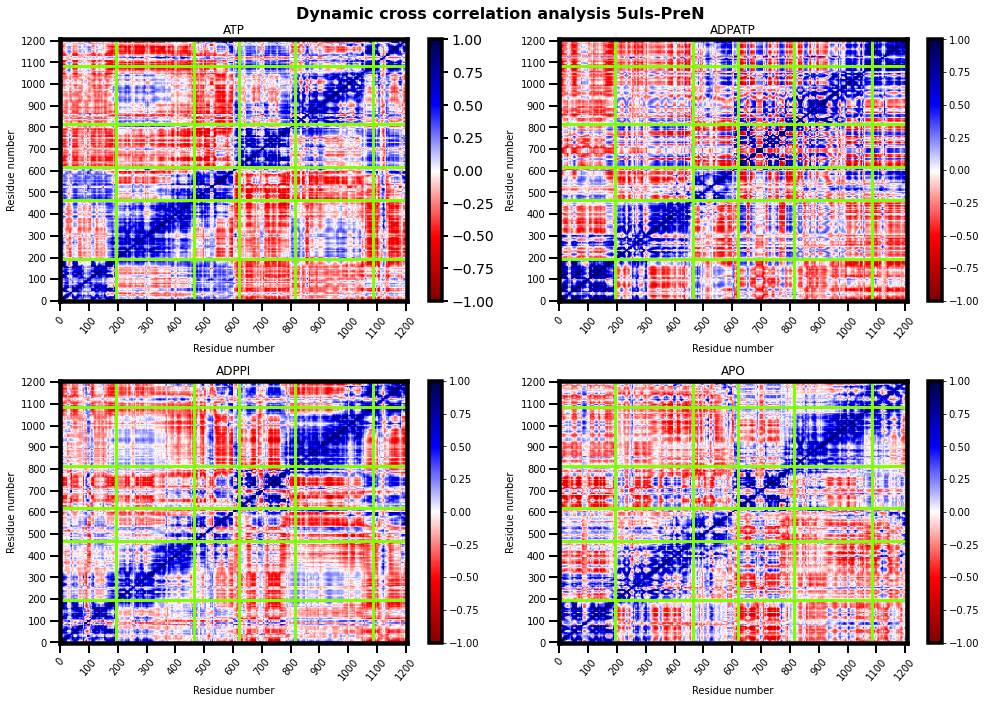

In [60]:
# fig = plt.figure(figsize=(14,14), dpi=300)
# fig.patch.set_facecolor('white')
# fig.patch.set_alpha(1.0)
# kws = dict(cbar_kws=dict(orientation="vertical"))
# fig.suptitle("Dynamic cross correlation analysis 5uls-PreN", fontsize = 16, linespacing = 5, weight = 'bold')
# fig = plt.figure(figsize=(14,14))
# fig.suptitle("Dynamic cross correlation analysis 5uls-PreN", fontsize = 16, linespacing = 5, weight = 'bold')
# for i in range(4):
#     #df[i].set_axis(range(87,748),axis = 1)
#     #df[i].set_axis(range(87,748),axis = 0)
#     #df[i]=df[i].set_axis(range(87,1409),axis = 1)
#     #df[i]=df[i].set_axis(range(87,1409),axis = 0)
#     fig.add_subplot(3,2,i+1)
#     #ax = sns.heatmap(df[i], cmap='coolwarm',xticklabels=100, yticklabels= 100)
#     ax = sns.heatmap(df[i], cmap='seismic_r',xticklabels=100, yticklabels= 100, vmin=-1, vmax=1,**kws)
#     ax.set_title(name[i])
#     ax.set_xlabel('Residue number')
#     plt.xticks(rotation=50)
#     #ax.set_xticklabels(labels = (87,100,200,300,400,500,600,700))
#     #ax.set_yticklabels(labels = (87,100,200,300,400,500,600,700))
#     ax.set_ylabel('Residue number')
#     ax.invert_yaxis()
#     cax = plt.gcf().axes[1]
#     cax.tick_params(labelsize=14)
#     cax.tick_params(direction='out', length=6, width=2, colors='k')
#     colorbar=ax.collections[0].colorbar
#     colorbar.outline.set_edgecolor('k')
#     colorbar.outline.set_linewidth(3.5)
#     ax.tick_params(direction='out', length=10, width=2, colors='k'),
#     for _, spine in ax.spines.items():
#         spine.set_visible(True)
#         spine.set_linewidth(4.5)
#     #ax.set_xticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300 ])
#     #ax.set_xticklabels([87, 187, 287, 387, 487, 587, 687, 787, 887, 987, 1087, 1287, 1387,], fontsize=14, fontweight='bold')
#     #ax.set_yticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300])
#     #ax.set_yticklabels([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300], fontsize=14, fontweight='bold')
#     plt.axhline(y=194, xmin=-1, xmax=1, linewidth=3, color='chartreuse')
#     plt.axvline(x=194, ymin=-1, ymax=1, linewidth=3, color='chartreuse')
#     plt.axhline(y=466, xmin=-1, xmax=1, linewidth=3, color='chartreuse')
#     plt.axvline(x=466, ymin=-1, ymax=1, linewidth=3, color='chartreuse')
#     plt.axhline(y=620, xmin=-1, xmax=1, linewidth=3, color='chartreuse')
#     plt.axvline(x=620, ymin=-1, ymax=1, linewidth=3, color='chartreuse')
#     plt.axhline(y=814, xmin=-1, xmax=1, linewidth=3, color='chartreuse')
#     plt.axvline(x=814, ymin=-1, ymax=1, linewidth=3, color='chartreuse')
#     plt.axhline(y=1086, xmin=-1, xmax=1, linewidth=3, color='chartreuse')
#     plt.axvline(x=1086, ymin=-1, ymax=1, linewidth=3, color='chartreuse')
#     plt.axhline(y=1240, xmin=-1, xmax=1, linewidth=3, color='chartreuse')
#     plt.axvline(x=1240, ymin=-1, ymax=1, linewidth=3, color='chartreuse')
#     plt.rcParams["axes.edgecolor"]="black"
#     plt.rcParams["axes.linewidth"]=2.5
# plt.tight_layout()
# plt.savefig('/home/alaooj/namd/5uls/test.png')

## Crosscorrelation without charge linker

## write dcd and PDB for correlation matrix

In [53]:
unin = {'ATP': u, 'ADPATP' : u1 , 'ADPPI' : u2, 'APO': u3}


In [55]:
for key, value in unin.items():
    protein = value.select_atoms("name CA and not resid 280-337")
    protein.write("/home/alaooj/namd/5uls/5uls-{0}/prep/namd/protein_corr.pdb".format(key.lower()))
    with mda.Writer("/home/alaooj/namd/5uls/5uls-{0}/prep/namd/protein_corr.dcd".format(key.lower()), protein.n_atoms) as W:
        for ts in value.trajectory:
            W.write(protein)

The use correlationplus to generate the correlation matrix
using 

correlationplus calculate -p protein_corr.pdb -f protein_corr.dcd -o correllationplus_all.dat
script location /home/alaooj/namd/5uls/correlationplush.sh

https://correlationplus.readthedocs.io/en/latest/installation.html

In [8]:
df0 = pd.read_csv('/home/alaooj/namd/5uls/5uls-atp/prep/namd/correlationplus_all.dat', sep='\s+', header = None)#  index_col=[0])
df1 = pd.read_csv('/home/alaooj/namd/5uls/5uls-adpatp/prep/namd/correlationplus_all.dat', sep='\s+', header = None)# index_col=[0])
df2 = pd.read_csv('/home/alaooj/namd/5uls/5uls-adppi/prep/namd/correlationplus_all.dat', sep='\s+', header = None)# index_col=[0])
df3 = pd.read_csv('/home/alaooj/namd/5uls/5uls-apo/prep/namd/correllation_all.dat', sep='\s+', header = None)# index_col=[0])

In [261]:
df = [df0,df1,df2,df3]
name = ['ATP','ADP/ATP','ADP-Pi','apo']

In [51]:
#!find . -name "corre*.dat"-delete

<Figure size 14000x14000 with 0 Axes>

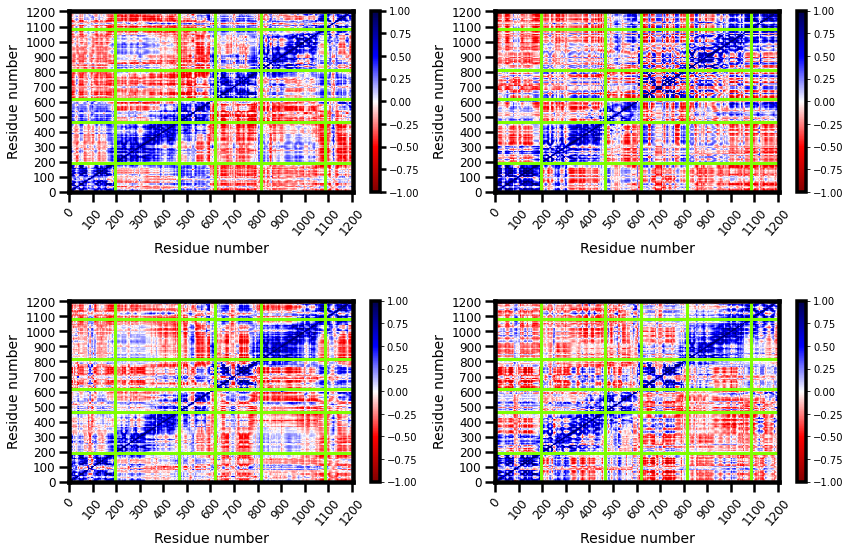

In [279]:
fig = plt.figure(figsize=(14,14), dpi=1000)
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)
kws = dict(cbar_kws=dict(orientation="vertical"))
#fig.suptitle("Dynamic cross correlation analysis 5uls-PreN", fontsize = 16, linespacing = 5, weight = 'bold')
fig = plt.figure(figsize=(14,14))
#fig.suptitle("Dynamic cross correlation analysis 5uls-PreN", fontsize = 16, linespacing = 5, weight = 'bold')
for i in range(4):
    #df[i].set_axis(range(87,748),axis = 1)
    #df[i].set_axis(range(87,748),axis = 0)
    #df[i]=df[i].set_axis(range(87,1409),axis = 1)
    #df[i]=df[i].set_axis(range(87,1409),axis = 0)
    fig.add_subplot(3,2,i+1)
    #ax = sns.heatmap(df[i], cmap='coolwarm',xticklabels=100, yticklabels= 100)
    ax = sns.heatmap(df[i], cmap='seismic_r',xticklabels=100, yticklabels= 100, vmin=-1, vmax=1,**kws)
    #ax.set_title(name[i], fontsize = 16, weight = 'bold')
    ax.set_xlabel('Residue number', fontsize = 14)
    plt.xticks(rotation=50, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    #ax.set_xticklabels(labels = (87,100,200,300,400,500,600,700))
    #ax.set_yticklabels(labels = (87,100,200,300,400,500,600,700))
    ax.set_ylabel('Residue number', fontsize = 14)
    ax.invert_yaxis()
    cax = plt.gcf().axes[1]
    cax.tick_params(labelsize=10)
    cax.tick_params(direction='out', length=6, width=2.5, colors='k')
    colorbar=ax.collections[0].colorbar
    colorbar.outline.set_edgecolor('k')
    colorbar.outline.set_linewidth(3.5)
    ax.tick_params(direction='out', length=10, width=2.5, colors='k'),
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(4.5)
    #ax.set_xticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300 ])
    #ax.set_xticklabels([87, 187, 287, 387, 487, 587, 687, 787, 887, 987, 1087, 1287, 1387,], fontsize=14, fontweight='bold')
    #ax.set_yticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300])
    #ax.set_yticklabels([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300], fontsize=14, fontweight='bold')
    plt.axhline(y=194, xmin=-1, xmax=1, linewidth=3, color='chartreuse')
    plt.axvline(x=194, ymin=-1, ymax=1, linewidth=3, color='chartreuse')
    plt.axhline(y=466, xmin=-1, xmax=1, linewidth=3, color='chartreuse')
    plt.axvline(x=466, ymin=-1, ymax=1, linewidth=3, color='chartreuse')
    plt.axhline(y=620, xmin=-1, xmax=1, linewidth=3, color='chartreuse')
    plt.axvline(x=620, ymin=-1, ymax=1, linewidth=3, color='chartreuse')
    plt.axhline(y=814, xmin=-1, xmax=1, linewidth=3, color='chartreuse')
    plt.axvline(x=814, ymin=-1, ymax=1, linewidth=3, color='chartreuse')
    plt.axhline(y=1086, xmin=-1, xmax=1, linewidth=3, color='chartreuse')
    plt.axvline(x=1086, ymin=-1, ymax=1, linewidth=3, color='chartreuse')
    plt.axhline(y=1240, xmin=-1, xmax=1, linewidth=3, color='chartreuse')
    plt.axvline(x=1240, ymin=-1, ymax=1, linewidth=3, color='chartreuse')
    plt.rcParams["axes.edgecolor"]="black"
    plt.rcParams["axes.linewidth"]=2.5
    plt.subplots_adjust(hspace= .6)
#plt.tight_layout()
plt.savefig('/home/alaooj/namd/5uls/DCC.png')

# Write out pdb of desired frame

In [ ]:
for key, value in uni.items():
    ag = value.select_atoms("protein or (segid HET*) or (segid LIG*) or (around 3.5 resname LIG*) or (around 3.5 resname ATP)")
    ag.write("/home/alaooj/namd/5uls/results/lastframe/{0}_frame2000.pdb".format(key), frames=value.trajectory[[-1,1,-1]])


# Visualisation

In [ ]:
nv.show_mdanalysis(u4)

# PCA

#tutorial
https://userguide.mdanalysis.org/stable/examples/analysis/reduced_dimensions/pca.html

In [152]:
#u  = mda.Universe('/home/nguyenq3/namd/5uls/5uls-anp/prep/namd/step3_charmm2namd.psf', '/home/nguyenq3/namd/5uls/5uls-anp/prep/namd/eq10_all.dcd')  
u1 = mda.Universe('/home/nguyenq3/namd/5uls/5uls-adpatp/prep/namd/step3_charmm2namd.psf', '/home/nguyenq3/namd/5uls/5uls-adpatp/prep/namd/eq50_all.dcd') 
u2 = mda.Universe('/home/nguyenq3/namd/5uls/5uls-adppi/prep/namd/step3_charmm2namd.psf', '/home/nguyenq3/namd/5uls/5uls-adppi/prep/namd/eq50_all.dcd')
u = mda.Universe('/home/nguyenq3/namd/5uls/5uls-atp/prep/namd/step3_charmm2namd.psf', '/home/nguyenq3/namd/5uls/5uls-atp/prep/namd/eq50_all.dcd')
u3 = mda.Universe('/home/nguyenq3/namd/5uls/5uls-apo/prep/namd/step3_charmm2namd.psf', '/home/nguyenq3/namd/5uls/5uls-apo/prep/namd/eq10_all.dcd')

In [153]:
dir_dict = {
            "/home/alaooj/namd/5uls/5uls-adpatp/prep/namd/": u, 
            "/home/alaooj/namd/5uls/5uls-adppi/prep/namd/": u1,
            "/home/alaooj/namd/5uls/5uls-atp/prep/namd/": u2,
            "/home/alaooj/namd/5uls/5uls-apo/prep/namd/": u3}

In [154]:
#This function separate pc into 3 columns for x, y, z. 
#The function returns a dataframe that is ready to be saved as txt file
def sep_pc_xyz (xyz):
    x = []
    y = []
    z = []
    i = 0
    while i < len(xyz):
        if i%3 == 0:
            x.append(xyz[i])
        elif i%3 == 1:
            y.append(xyz[i])
        else:
            z.append(xyz[i])
        i+=1
    df = pd.DataFrame(list(zip(x,y,z)))
    return df

In [155]:
pc_collection=[]
for key in dir_dict.keys():
    u = dir_dict[key]
    print(key)
    aligner = align.AlignTraj(u, u, select='name CA and not resid 283-331',in_memory=True).run()
    pc = pca.PCA(u, select='name CA and not resid 283-331',align=False, mean=None, n_components=None).run()
    calphas = u.select_atoms("name CA and not resid 283-331")
    calphas.write(key+ "CA_withoutloop.pdb")
    backbone = u.select_atoms('name CA and not resid 283-331')
    transformed = pc.transform(calphas, n_components=5)
    
    df = pd.DataFrame(transformed,
                  columns=['PC{}'.format(i+1) for i in range(5)])
    df['Time (ps)'] = df.index * u.trajectory.dt
    pc_collection.append(df)
    df.to_csv(key + 'pc.csv',  index = False,) #header = False,) # this contain pc1 to pc5
    #PC1
    pc1 = pc.p_components[:, 0]
    pc1 = np.asarray(pc1)
    np.savetxt(key +"pc1.txt",pc1)
    df_pc1 = sep_pc_xyz(pc1)
    df_pc1.to_csv(key + 'pc1_t.txt',  index = False)
    #! "/home/nguyenq3/namd/general_code/pca_tcl_arrow.py" "/home/nguyenq3/namd/general_code/arrow_template/template1.tcl" key+"pc1.txt" 1 1322 key+"arrow1.tcl"
    #PC2
    pc2 = pc.p_components[:, 1]
    pc2 = np.asarray(pc2)
    np.savetxt(key + "pc2.txt",pc2)
    df_pc1 = sep_pc_xyz(pc2)
    df_pc1.to_csv(key + 'pc2_t.txt',  index = False)
    #!. (/home/nguyenq3/namd/general_code/pca_tcl_arrow.py) /home/nguyenq3/namd/general_code/arrow_template/template2.tcl key+"pc2.txt" 1 1322 key + "arrow2.tcl"
    #PC3
    pc3 = pc.p_components[:, 2]
    pc3 = np.asarray(pc3)
    np.savetxt(key + "pc3.txt",pc3)
    df_pc1 = sep_pc_xyz(pc3)
    df_pc1.to_csv(key + 'pc3_t.txt',  index = False)

/home/alaooj/namd/5uls/5uls-adpatp/prep/namd/
/home/alaooj/namd/5uls/5uls-adppi/prep/namd/
/home/alaooj/namd/5uls/5uls-atp/prep/namd/
/home/alaooj/namd/5uls/5uls-apo/prep/namd/


In [291]:
dp0 = pd.read_csv("/home/alaooj/namd/5uls/5uls-atp/prep/namd/pc1.txt", sep='\s+', header = None)
dc0 = pd.read_csv("/home/alaooj/namd/5uls/5uls-atp/prep/namd/pc2.txt", sep='\s+', header = None)# index_col=[0])
dp1 = pd.read_csv("/home/alaooj/namd/5uls/5uls-adpatp/prep/namd/pc1.txt", sep='\s+', header = None)
dc1= pd.read_csv("/home/alaooj/namd/5uls/5uls-adpatp/prep/namd/pc2.txt", sep='\s+', header = None)
dp2 = pd.read_csv("/home/alaooj/namd/5uls/5uls-adppi/prep/namd/pc1.txt", sep='\s+', header = None)
dc2 = pd.read_csv("/home/alaooj/namd/5uls/5uls-adppi/prep/namd/pc2.txt", sep='\s+', header = None)
dp3 = pd.read_csv("/home/alaooj/namd/5uls/5uls-apo/prep/namd/pc1.txt", sep='\s+', header = None)
dc3 = pd.read_csv("/home/alaooj/namd/5uls/5uls-apo/prep/namd/pc2.txt", sep='\s+', header = None)

In [292]:
dfy = [dp0,dp1,dp2,dp3]
dfx = [dc0,dc1,dc2,dc3]

name = ['ATP','ADPATP','ADPPI','APO']

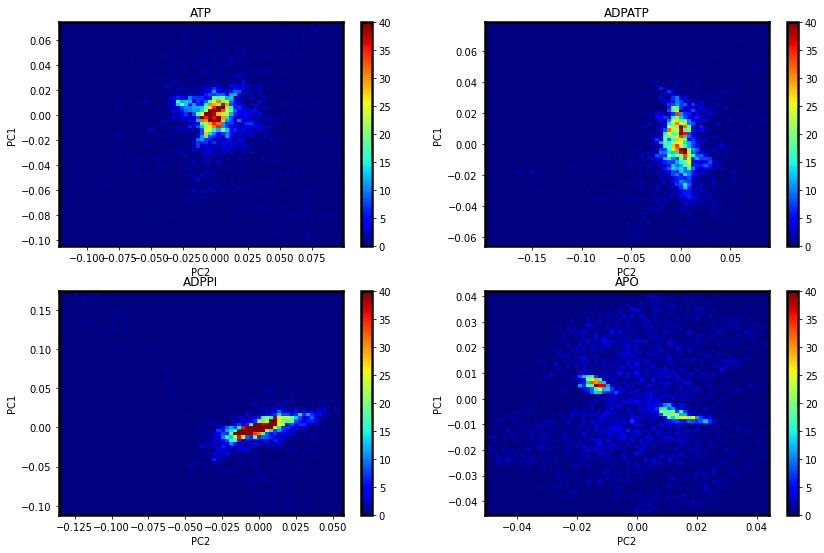

In [163]:
fig = plt.figure(figsize=(14,14))
# x=dp0[0]
# y=dc0[0]
# #plt.hist2d(x, y, bins=(70, 70), cmap='seismic', label=["PC PLOT"],)
# plt.hist2d(x, y, bins=(70, 70), cmap='jet', label=["PC PLOT"],)
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.colorbar()


for i in range(4):

    x=dfx[i][0]
    y=dfy[i][0]
    fig.add_subplot(3,2,i+1)
    #plt.hist2d(x, y, bins=(70, 70), cmap='seismic', label=["PC PLOT"],)
    plt.hist2d(x, y, bins=(70, 70), cmap='jet', label=["PC PLOT"], vmin=0, vmax=40)
    plt.xlabel("PC2")
    plt.ylabel("PC1")
    plt.title(name[i])
    plt.colorbar()
    #plt.ylim(-0.10, 0.4)
    #plt.xlim(-0.2, 0.2)
    


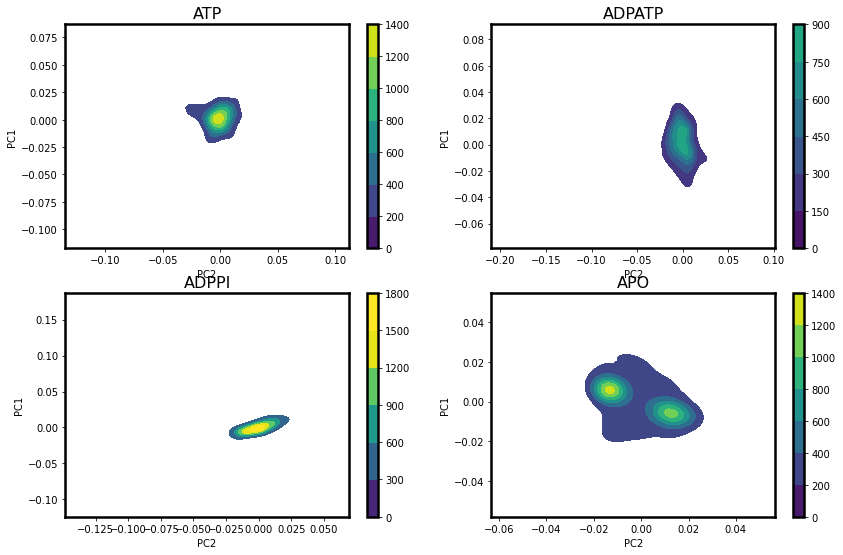

In [164]:
from scipy.stats import gaussian_kde
fig = plt.figure(figsize=(14,14))
# x=dp0[0]
# y=dc0[0]
# #plt.hist2d(x, y, bins=(70, 70), cmap='seismic', label=["PC PLOT"],)
# plt.hist2d(x, y, bins=(70, 70), cmap='jet', label=["PC PLOT"],)
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.colorbar()
for i in range(4):
    x=dfx[i][0]
    y=dfy[i][0]
    fig.add_subplot(3,2,i+1)
# fit an array of size [Ndim, Nsamples]
    sns.kdeplot(x, y, zorder=0, n_levels=6, shade=True,
    cbar=True, shade_lowest=False, cmap='viridis',vmax=1400)
    #cb.set_label("density")
    #plt.hist2d(x, y, bins=(70, 70), cmap='seismic', label=["PC PLOT"],)
    #Z=kde.evaluate(x,y([Xgrid.ravel(), Ygrid.ravel()]))
    #plt.imshow(Z.reshape())
    #plt.hist2d(x, y, bins=(100, 100), cmap='jet', label=["PC PLOT"], vmin=0, vmax=40, range=[(-0.1, 0.1),(-0.1, 0.1)])
    plt.xlabel("PC2")
    plt.ylabel("PC1")
    plt.title(name[i],fontsize=16)
    #plt.colorbar()
    #plt.ylim(-0.10, 0.4)
    #plt.xlim(-0.2, 0.2)
plt.savefig('/home/alaooj/pc1vpc2-grp94nuc.png', dpi=300);

<function matplotlib.pyplot.show(close=None, block=None)>

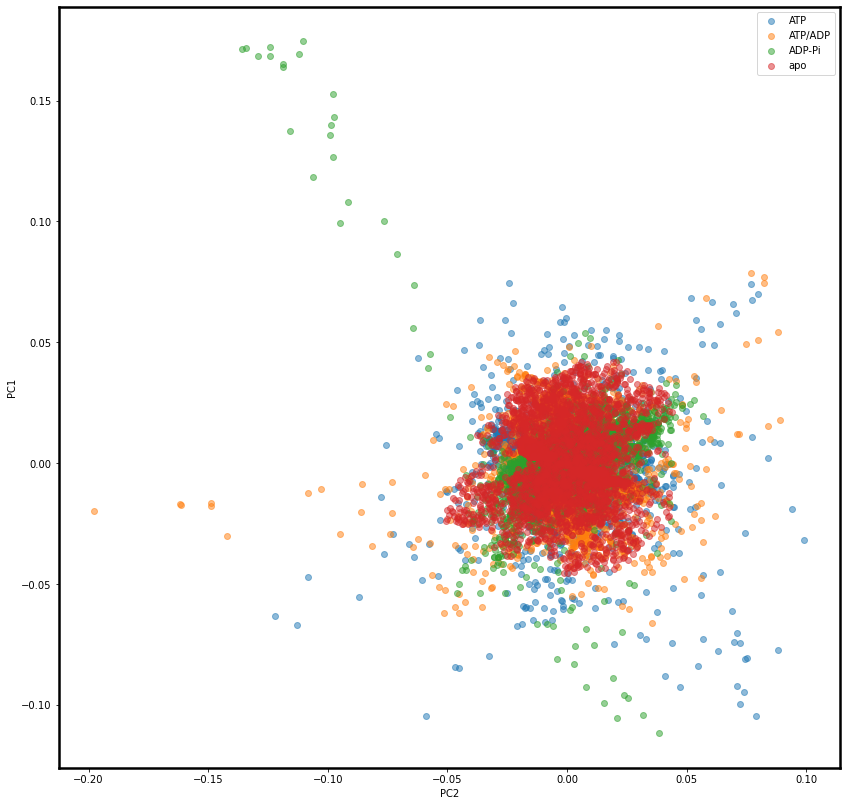

In [301]:
fig = plt.figure(figsize=(14,14))
# x=dp0[0]
# y=dc0[0]
# #plt.hist2d(x, y, bins=(70, 70), cmap='seismic', label=["PC PLOT"],)
# plt.hist2d(x, y, bins=(70, 70), cmap='jet', label=["PC PLOT"],)
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.colorbar()

for i in range(4):
    x=dfx[i][0]
    y=dfy[i][0]
    #fig.add_subplot(3,2,i+1)
    #plt.hist2d(x, y, bins=(70, 70), cmap='seismic', label=["PC PLOT"],)
    #plt.hist2d(x, y, bins=(70, 70), cmap='jet', label=["PC PLOT"], vmin=0, vmax=40)
    plt.scatter(x, y, label=name_collection1[i], alpha=0.5)
    plt.xlabel("PC2")
    plt.ylabel("PC1")
    #plt.title(name[i])
    #plt.colorbar()
    #plt.ylim(-0.10, 0.4)
    #plt.xlim(-0.2, 0.2)
plt.legend()    
plt.show

In [ ]:
# I was plotting this before. I think its wrong

In [127]:
# pc0 = pd.read_csv("/home/alaooj/namd/5uls/5uls-atp/prep/namd/pc.csv", sep=',' , ) #header = None)
# pc1 = pd.read_csv("/home/alaooj/namd/5uls/5uls-adpatp/prep/namd/pc.csv", sep=',',) # header = None)# index_col=[0])
# pc2 = pd.read_csv("/home/alaooj/namd/5uls/5uls-adppi/prep/namd/pc.csv", sep=',', ) #header = None)
# pc3= pd.read_csv("/home/alaooj/namd/5uls/5uls-apo/prep/namd/pc.csv", sep=',', ) #header = None)

In [129]:
# df = [pc0,pc1,pc2,pc3]
# name = ['ATP','ADPATP','ADPPI','APO']

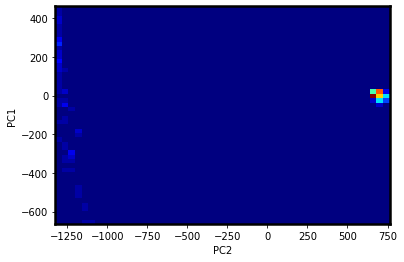

In [130]:
# for i in range(4):
#     #df[i].set_axis(range(87,748),axis = 1)
#     #df[i].set_axis(range(87,748),axis = 0)
#     #df[i]=df[i].set_axis(range(87,1409),axis = 1)
#     #df[i]=df[i].set_axis(range(87,1409),axis = 0)
#     x=df[i]['PC1']
#     y=df[i]['PC2']
#     fig.add_subplot(3,2,i+1)
#     #plt.hist2d(x, y, bins=(70, 70), cmap='seismic', label=["PC PLOT"],)
#     plt.hist2d(x, y, bins=(50, 50), cmap='jet', label=["PC PLOT"],)
#     plt.xlabel("PC2")
#     plt.ylabel("PC1")
#     i=i+1

# notes

The parameters for subplot are: number of rows, number of columns, and which subplot you're currently on. So 1, 2, 1 means "a 1-row, 2-column figure: go to the first subplot." Then 1, 2, 2 means "a 1-row, 2-column figure: go to the second subplot."

